## Import required Libraries

In [1]:
!pip3 install pactools
!pip3 install xgboost
!pip3 install s3fs

import tqdm
from sklearn.pipeline import Pipeline

from pactools import simulate_pac
from pactools.grid_search import ExtractDriver, AddDriverDelay
from pactools.grid_search import DARSklearn, MultipleArray
from pactools.grid_search import GridSearchCVProgressBar

import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier,XGBRegressor
from sklearn.metrics import confusion_matrix
import s3fs
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

## Read the data

In [3]:
ead_df_train_age_pred_x = pd.read_csv('ead_df_train_age_pred_x.csv')
ead_df_train_age_pred_y = pd.read_csv('ead_df_train_age_pred_y.csv')
ead_df_test_age_pred_x = pd.read_csv('ead_df_test_age_pred_x.csv')
ead_df_test_age_pred_y = pd.read_csv('ead_df_test_age_pred_y.csv')
ead_df_test_age_pred_x_with_device_id = pd.read_csv('ead_df_test_age_pred_x_with_device_id.csv')
ead_df_train_gender_pred_x = pd.read_csv('ead_df_train_gender_pred_x.csv')
ead_df_train_gender_pred_y = pd.read_csv('ead_df_train_gender_pred_y.csv')
ead_df_test_gender_pred_x = pd.read_csv('ead_dfd_test_gender_pred_x.csv')
ead_df_test_gender_pred_y = pd.read_csv('ead_df_test_gender_pred_y.csv')
ead_df_test_gender_pred_x_with_device_id = pd.read_csv('ead_df_test_gender_pred_x_with_device_id.csv')

In [4]:
ead_df_train_age_pred_x.drop('Unnamed: 0',axis=1,inplace=True)
ead_df_train_age_pred_y.drop('Unnamed: 0',axis=1,inplace=True)
ead_df_test_age_pred_x.drop('Unnamed: 0',axis=1,inplace=True)
ead_df_test_age_pred_y.drop('Unnamed: 0',axis=1,inplace=True)
ead_df_test_age_pred_x_with_device_id.drop('Unnamed: 0',axis=1,inplace=True)
ead_df_train_gender_pred_x.drop('Unnamed: 0',axis=1,inplace=True)
ead_df_train_gender_pred_y.drop('Unnamed: 0',axis=1,inplace=True)
ead_df_test_gender_pred_x.drop('Unnamed: 0',axis=1,inplace=True)
ead_df_test_gender_pred_y.drop('Unnamed: 0',axis=1,inplace=True)
ead_df_test_gender_pred_x_with_device_id.drop('Unnamed: 0',axis=1,inplace=True)

In [15]:
list(ead_df_train_age_pred_x.columns)

['gender',
 'device_avg_events',
 'lat_long_count',
 'device_median_latitude',
 'device_median_longitude',
 'device_app_count',
 'device_best_day_Friday',
 'device_best_day_Monday',
 'device_best_day_Saturday',
 'device_best_day_Sunday',
 'device_best_day_Thursday',
 'device_best_day_Tuesday',
 'device_best_day_Wednesday',
 'device_best_hourcat_Late Night',
 'device_best_hourcat_Early Morning',
 'device_best_hourcat_Morning',
 'device_best_hourcat_Afternoon',
 'device_best_hourcat_Evening',
 'device_best_hourcat_Night',
 'phone_brand_shrunk_Coolpad',
 'phone_brand_shrunk_Gionee',
 'phone_brand_shrunk_HTC',
 'phone_brand_shrunk_Huawei',
 'phone_brand_shrunk_Meizu',
 'phone_brand_shrunk_OPPO',
 'phone_brand_shrunk_Other',
 'phone_brand_shrunk_Sony',
 'phone_brand_shrunk_Xiaomi',
 'phone_brand_shrunk_ZTE',
 'phone_brand_shrunk_hammer',
 'phone_brand_shrunk_lenovo',
 'phone_brand_shrunk_lshi',
 'phone_brand_shrunk_nubia',
 'phone_brand_shrunk_samsung',
 'phone_brand_shrunk_vivo',
 'device_

## Data Segmentation into Scenario 1 and Scenario 2 data

In [5]:
scn1_df_train_age_pred_x = ead_df_train_age_pred_x.copy()
scn1_df_test_age_pred_x = ead_df_test_age_pred_x.copy()
scn1_df_train_age_pred_y = ead_df_train_age_pred_y.copy()
scn1_df_test_age_pred_y = ead_df_test_age_pred_y.copy()
scn1_df_train_gender_pred_x = ead_df_train_gender_pred_x.copy()
scn1_df_test_gender_pred_x = ead_df_test_gender_pred_x.copy()
scn1_df_train_gender_pred_y = ead_df_train_gender_pred_y.copy()
scn1_df_test_gender_pred_y = ead_df_test_gender_pred_y.copy()

scn1_df_train_age_pred_x.head()

gender  device_avg_events  lat_long_count  device_median_latitude  \
0       0          -0.126005       -0.126005               -0.865970   
1       1           0.381307        0.381307                0.035954   
2       0          -0.208443       -0.208443                1.885603   
3       0          -0.341613       -0.341613               -0.928212   
4       1          -0.360637       -0.360637               -0.894155   

   device_median_longitude  device_app_count  device_best_day_Friday  \
0                 0.127282          1.337343                       1   
1                 0.176157         -0.077599                       0   
2                 0.636102          1.782039                       0   
3                 0.161320         -1.047845                       1   
4                 0.137319         -0.441441                       0   

   device_best_day_Monday  device_best_day_Saturday  device_best_day_Sunday  \
0                       0                         0                       0   
1                       1                         0                       0   
2                       0                         0                       0   
3                       0                         0                       0   
4                       0                         0                       0   

   ...  device_model_shrunk_è£è€€ç•…çŽ©4X  device_model_shrunk_è£è€€ç•…çŽ©5  \
0  ...                                   0                                  0   
1  ...                                   0                                  0   
2  ...                                   0                                  0   
3  ...                                   0                                  0   
4  ...                                   0                                  0   

   device_model_shrunk_è£è€€ç•…çŽ©5X  device_model_shrunk_è¶…çº§æ‰‹æœº1  \
0                                   0                                  0   
1                                   0                                  0   
2                                   0                                  0   
3                                   0                                  0   
4                                   0                                  0   

   device_model_shrunk_è¶…çº§æ‰‹æœº1 Pro  device_model_shrunk_é’æ˜¥ç‰ˆ  \
0                                      0                              0   
1                                      0                              0   
2                                      0                              0   
3                                      0                              0   
4                                      0                              0   

   device_model_shrunk_é­…è“  device_model_shrunk_é­…è“2  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   device_model_shrunk_é­…è“metal  device_model_shrunk_éº¦èŠ’4  
0                                0                            0  
1                                0                            0  
2                                0                            0  
3                                0                            0  
4                                0                            0  

[5 rows x 155 columns]

In [6]:
scn1_df_test_age_pred_x.head()

gender  device_avg_events  lat_long_count  device_median_latitude  \
0       0          -0.347954       -0.347954               -0.230630   
1       0          -0.030884       -0.030884               -0.594688   
2       0          -0.316247       -0.316247               -0.395043   
3       0          -0.037225       -0.037225               -0.809599   
4       0          -0.417709       -0.417709                0.080581   

   device_median_longitude  device_app_count  device_best_day_Friday  \
0                 0.087571         -0.724430                       1   
1                 0.380383          3.156555                       0   
2                 0.048733         -0.845711                       0   
3                 0.118554          0.367097                       0   
4                 0.485550          0.286243                       1   

   device_best_day_Monday  device_best_day_Saturday  device_best_day_Sunday  \
0                       0                         0                       0   
1                       0                         0                       0   
2                       0                         0                       0   
3                       0                         0                       0   
4                       0                         0                       0   

   ...  device_model_shrunk_è£è€€ç•…çŽ©4X  device_model_shrunk_è£è€€ç•…çŽ©5  \
0  ...                                   0                                  0   
1  ...                                   0                                  0   
2  ...                                   0                                  0   
3  ...                                   0                                  0   
4  ...                                   0                                  0   

   device_model_shrunk_è£è€€ç•…çŽ©5X  device_model_shrunk_è¶…çº§æ‰‹æœº1  \
0                                   1                                  0   
1                                   0                                  1   
2                                   0                                  0   
3                                   0                                  0   
4                                   0                                  0   

   device_model_shrunk_è¶…çº§æ‰‹æœº1 Pro  device_model_shrunk_é’æ˜¥ç‰ˆ  \
0                                      0                              0   
1                                      0                              0   
2                                      0                              0   
3                                      0                              0   
4                                      0                              0   

   device_model_shrunk_é­…è“  device_model_shrunk_é­…è“2  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   device_model_shrunk_é­…è“metal  device_model_shrunk_éº¦èŠ’4  
0                                0                            0  
1                                0                            0  
2                                0                            0  
3                                0                            0  
4                                0                            0  

[5 rows x 155 columns]

In [7]:
scn1_df_train_age_pred_y

age
0     0.416589
1    -0.114934
2     0.841808
3    -1.496895
4    -0.965372
...        ...
8902  0.841808
8903 -0.433848
8904  0.948113
8905  0.310284
8906  0.203980

[8907 rows x 1 columns]

In [112]:
scn1_df_test_age_pred_y

age
0    -0.965372
1     0.948113
2    -0.965372
3     0.310284
4    -0.752762
...        ...
3037  2.223769
3038 -0.965372
3039 -0.965372
3040  0.203980
3041 -0.327544

[3042 rows x 1 columns]

In [28]:
scn1_df_train_gender_pred_x.head()

age  device_avg_events  lat_long_count  device_median_latitude  \
0  0.416589          -0.126005       -0.126005               -0.865970   
1 -0.114934           0.381307        0.381307                0.035954   
2  0.841808          -0.208443       -0.208443                1.885603   
3 -1.496895          -0.341613       -0.341613               -0.928212   
4 -0.965372          -0.360637       -0.360637               -0.894155   

   device_median_longitude  device_app_count  device_best_day_Friday  \
0                 0.127282          1.337343                       1   
1                 0.176157         -0.077599                       0   
2                 0.636102          1.782039                       0   
3                 0.161320         -1.047845                       1   
4                 0.137319         -0.441441                       0   

   device_best_day_Monday  device_best_day_Saturday  device_best_day_Sunday  \
0                       0                         0                       0   
1                       1                         0                       0   
2                       0                         0                       0   
3                       0                         0                       0   
4                       0                         0                       0   

   ...  device_model_shrunk_è£è€€ç•…çŽ©4X  device_model_shrunk_è£è€€ç•…çŽ©5  \
0  ...                                   0                                  0   
1  ...                                   0                                  0   
2  ...                                   0                                  0   
3  ...                                   0                                  0   
4  ...                                   0                                  0   

   device_model_shrunk_è£è€€ç•…çŽ©5X  device_model_shrunk_è¶…çº§æ‰‹æœº1  \
0                                   0                                  0   
1                                   0                                  0   
2                                   0                                  0   
3                                   0                                  0   
4                                   0                                  0   

   device_model_shrunk_è¶…çº§æ‰‹æœº1 Pro  device_model_shrunk_é’æ˜¥ç‰ˆ  \
0                                      0                              0   
1                                      0                              0   
2                                      0                              0   
3                                      0                              0   
4                                      0                              0   

   device_model_shrunk_é­…è“  device_model_shrunk_é­…è“2  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   device_model_shrunk_é­…è“metal  device_model_shrunk_éº¦èŠ’4  
0                                0                            0  
1                                0                            0  
2                                0                            0  
3                                0                            0  
4                                0                            0  

[5 rows x 155 columns]

In [30]:
scn1_df_train_gender_pred_y

gender
0          0
1          1
2          0
3          0
4          1
...      ...
8902       0
8903       0
8904       0
8905       0
8906       0

[8907 rows x 1 columns]

In [29]:
scn1_df_test_gender_pred_x.head()

age  device_avg_events  lat_long_count  device_median_latitude  \
0 -0.965372          -0.347954       -0.347954               -0.230630   
1  0.948113          -0.030884       -0.030884               -0.594688   
2 -0.965372          -0.316247       -0.316247               -0.395043   
3  0.310284          -0.037225       -0.037225               -0.809599   
4 -0.752762          -0.417709       -0.417709                0.080581   

   device_median_longitude  device_app_count  device_best_day_Friday  \
0                 0.087571         -0.724430                       1   
1                 0.380383          3.156555                       0   
2                 0.048733         -0.845711                       0   
3                 0.118554          0.367097                       0   
4                 0.485550          0.286243                       1   

   device_best_day_Monday  device_best_day_Saturday  device_best_day_Sunday  \
0                       0                         0                       0   
1                       0                         0                       0   
2                       0                         0                       0   
3                       0                         0                       0   
4                       0                         0                       0   

   ...  device_model_shrunk_è£è€€ç•…çŽ©4X  device_model_shrunk_è£è€€ç•…çŽ©5  \
0  ...                                   0                                  0   
1  ...                                   0                                  0   
2  ...                                   0                                  0   
3  ...                                   0                                  0   
4  ...                                   0                                  0   

   device_model_shrunk_è£è€€ç•…çŽ©5X  device_model_shrunk_è¶…çº§æ‰‹æœº1  \
0                                   1                                  0   
1                                   0                                  1   
2                                   0                                  0   
3                                   0                                  0   
4                                   0                                  0   

   device_model_shrunk_è¶…çº§æ‰‹æœº1 Pro  device_model_shrunk_é’æ˜¥ç‰ˆ  \
0                                      0                              0   
1                                      0                              0   
2                                      0                              0   
3                                      0                              0   
4                                      0                              0   

   device_model_shrunk_é­…è“  device_model_shrunk_é­…è“2  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   device_model_shrunk_é­…è“metal  device_model_shrunk_éº¦èŠ’4  
0                                0                            0  
1                                0                            0  
2                                0                            0  
3                                0                            0  
4                                0                            0  

[5 rows x 155 columns]

In [31]:
scn1_df_test_gender_pred_y

gender
0          0
1          0
2          0
3          0
4          0
...      ...
3037       0
3038       0
3039       0
3040       1
3041       1

[3042 rows x 1 columns]

In [46]:
scn2_df_train_age_pred_x = ead_df_train_age_pred_x.loc[:, ~ead_df_train_age_pred_x.columns.isin(['Unnamed: 0', 'device_avg_events',
 'lat_long_count',
 'device_median_latitude',
 'device_median_longitude',
 'device_app_count',
 'device_best_day_Friday',
 'device_best_day_Monday',
 'device_best_day_Saturday',
 'device_best_day_Sunday',
 'device_best_day_Thursday',
 'device_best_day_Tuesday',
 'device_best_day_Wednesday','device_best_hourcat_Early Morning',
 'device_best_hourcat_Morning',
 'device_best_hourcat_Afternoon',
 'device_best_hourcat_Evening',
 'device_best_hourcat_Night',
 'device_best_labelcategory_entertainment',
 'device_best_labelcategory_finance',
 'device_best_labelcategory_games',
 'device_best_labelcategory_health',
 'device_best_labelcategory_others',
 'device_best_labelcategory_real_estate',
 'device_best_labelcategory_travel'])]

In [47]:
scn2_df_train_age_pred_x.shape

(8907, 131)

In [9]:
scn2_df_test_age_pred_x = ead_df_test_age_pred_x.loc[:, ~ead_df_test_age_pred_x.columns.isin(['Unnamed: 0', 'device_avg_events',
 'lat_long_count',
 'device_median_latitude',
 'device_median_longitude',
 'device_app_count',
 'device_best_day_Friday',
 'device_best_day_Monday',
 'device_best_day_Saturday',
 'device_best_day_Sunday',
 'device_best_day_Thursday',
 'device_best_day_Tuesday',
 'device_best_day_Wednesday','device_best_hourcat_Early Morning',
 'device_best_hourcat_Morning',
 'device_best_hourcat_Afternoon',
 'device_best_hourcat_Evening',
 'device_best_hourcat_Night',
 'device_best_labelcategory_entertainment',
 'device_best_labelcategory_finance',
 'device_best_labelcategory_games',
 'device_best_labelcategory_health',
 'device_best_labelcategory_others',
 'device_best_labelcategory_real_estate',
 'device_best_labelcategory_travel'])]

In [12]:
scn2_df_test_age_pred_x.head()

gender  device_best_hourcat_Late Night  phone_brand_shrunk_Coolpad  \
0       0                               1                           0   
1       0                               1                           0   
2       0                               0                           0   
3       0                               0                           0   
4       0                               0                           0   

   phone_brand_shrunk_Gionee  phone_brand_shrunk_HTC  \
0                          0                       0   
1                          0                       0   
2                          0                       0   
3                          0                       0   
4                          0                       0   

   phone_brand_shrunk_Huawei  phone_brand_shrunk_Meizu  \
0                          1                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          1                         0   

   phone_brand_shrunk_OPPO  phone_brand_shrunk_Other  phone_brand_shrunk_Sony  \
0                        0                         0                        0   
1                        0                         0                        0   
2                        1                         0                        0   
3                        0                         0                        0   
4                        0                         0                        0   

   ...  device_model_shrunk_è£è€€ç•…çŽ©4X  device_model_shrunk_è£è€€ç•…çŽ©5  \
0  ...                                   0                                  0   
1  ...                                   0                                  0   
2  ...                                   0                                  0   
3  ...                                   0                                  0   
4  ...                                   0                                  0   

   device_model_shrunk_è£è€€ç•…çŽ©5X  device_model_shrunk_è¶…çº§æ‰‹æœº1  \
0                                   1                                  0   
1                                   0                                  1   
2                                   0                                  0   
3                                   0                                  0   
4                                   0                                  0   

   device_model_shrunk_è¶…çº§æ‰‹æœº1 Pro  device_model_shrunk_é’æ˜¥ç‰ˆ  \
0                                      0                              0   
1                                      0                              0   
2                                      0                              0   
3                                      0                              0   
4                                      0                              0   

   device_model_shrunk_é­…è“  device_model_shrunk_é­…è“2  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   device_model_shrunk_é­…è“metal  device_model_shrunk_éº¦èŠ’4  
0                                0                            0  
1                                0                            0  
2                                0                            0  
3                                0                            0  
4                                0                            0  

[5 rows x 131 columns]

In [13]:
scn2_df_train_age_pred_x.head()

gender  device_best_hourcat_Late Night  phone_brand_shrunk_Coolpad  \
0       0                               0                           0   
1       1                               0                           0   
2       0                               0                           0   
3       0                               0                           0   
4       1                               0                           0   

   phone_brand_shrunk_Gionee  phone_brand_shrunk_HTC  \
0                          0                       0   
1                          0                       0   
2                          0                       0   
3                          0                       1   
4                          0                       0   

   phone_brand_shrunk_Huawei  phone_brand_shrunk_Meizu  \
0                          0                         0   
1                          0                         0   
2                          1                         0   
3                          0                         0   
4                          0                         0   

   phone_brand_shrunk_OPPO  phone_brand_shrunk_Other  phone_brand_shrunk_Sony  \
0                        0                         0                        0   
1                        0                         0                        0   
2                        0                         0                        0   
3                        0                         0                        0   
4                        0                         0                        0   

   ...  device_model_shrunk_è£è€€ç•…çŽ©4X  device_model_shrunk_è£è€€ç•…çŽ©5  \
0  ...                                   0                                  0   
1  ...                                   0                                  0   
2  ...                                   0                                  0   
3  ...                                   0                                  0   
4  ...                                   0                                  0   

   device_model_shrunk_è£è€€ç•…çŽ©5X  device_model_shrunk_è¶…çº§æ‰‹æœº1  \
0                                   0                                  0   
1                                   0                                  0   
2                                   0                                  0   
3                                   0                                  0   
4                                   0                                  0   

   device_model_shrunk_è¶…çº§æ‰‹æœº1 Pro  device_model_shrunk_é’æ˜¥ç‰ˆ  \
0                                      0                              0   
1                                      0                              0   
2                                      0                              0   
3                                      0                              0   
4                                      0                              0   

   device_model_shrunk_é­…è“  device_model_shrunk_é­…è“2  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   device_model_shrunk_é­…è“metal  device_model_shrunk_éº¦èŠ’4  
0                                0                            0  
1                                0                            0  
2                                0                            0  
3                                0                            0  
4                                0                            0  

[5 rows x 131 columns]

In [16]:
scn2_df_train_age_pred_y = scn1_df_train_age_pred_y.copy()
scn2_df_test_age_pred_y = scn1_df_test_age_pred_y.copy()
scn2_df_train_gender_pred_y = scn1_df_train_gender_pred_y.copy()
scn2_df_test_gender_pred_y = scn1_df_test_gender_pred_y.copy()

In [15]:
scn2_df_train_age_pred_y.head()

age
0  0.416589
1 -0.114934
2  0.841808
3 -1.496895
4 -0.965372

In [18]:
scn2_df_test_age_pred_y.head()

age
0 -0.965372
1  0.948113
2 -0.965372
3  0.310284
4 -0.752762

In [19]:
scn2_df_train_gender_pred_x = ead_df_train_gender_pred_x.loc[:, ~ead_df_train_gender_pred_x.columns.isin(['Unnamed: 0', 'device_avg_events',
 'lat_long_count',
 'device_median_latitude',
 'device_median_longitude',
 'device_app_count',
 'device_best_day_Friday',
 'device_best_day_Monday',
 'device_best_day_Saturday',
 'device_best_day_Sunday',
 'device_best_day_Thursday',
 'device_best_day_Tuesday',
 'device_best_day_Wednesday','device_best_hourcat_Early Morning',
 'device_best_hourcat_Morning',
 'device_best_hourcat_Afternoon',
 'device_best_hourcat_Evening',
 'device_best_hourcat_Night',
 'device_best_labelcategory_entertainment',
 'device_best_labelcategory_finance',
 'device_best_labelcategory_games',
 'device_best_labelcategory_health',
 'device_best_labelcategory_others',
 'device_best_labelcategory_real_estate',
 'device_best_labelcategory_travel'])]

In [22]:
scn2_df_train_gender_pred_x.head()

age  device_best_hourcat_Late Night  phone_brand_shrunk_Coolpad  \
0  0.416589                               0                           0   
1 -0.114934                               0                           0   
2  0.841808                               0                           0   
3 -1.496895                               0                           0   
4 -0.965372                               0                           0   

   phone_brand_shrunk_Gionee  phone_brand_shrunk_HTC  \
0                          0                       0   
1                          0                       0   
2                          0                       0   
3                          0                       1   
4                          0                       0   

   phone_brand_shrunk_Huawei  phone_brand_shrunk_Meizu  \
0                          0                         0   
1                          0                         0   
2                          1                         0   
3                          0                         0   
4                          0                         0   

   phone_brand_shrunk_OPPO  phone_brand_shrunk_Other  phone_brand_shrunk_Sony  \
0                        0                         0                        0   
1                        0                         0                        0   
2                        0                         0                        0   
3                        0                         0                        0   
4                        0                         0                        0   

   ...  device_model_shrunk_è£è€€ç•…çŽ©4X  device_model_shrunk_è£è€€ç•…çŽ©5  \
0  ...                                   0                                  0   
1  ...                                   0                                  0   
2  ...                                   0                                  0   
3  ...                                   0                                  0   
4  ...                                   0                                  0   

   device_model_shrunk_è£è€€ç•…çŽ©5X  device_model_shrunk_è¶…çº§æ‰‹æœº1  \
0                                   0                                  0   
1                                   0                                  0   
2                                   0                                  0   
3                                   0                                  0   
4                                   0                                  0   

   device_model_shrunk_è¶…çº§æ‰‹æœº1 Pro  device_model_shrunk_é’æ˜¥ç‰ˆ  \
0                                      0                              0   
1                                      0                              0   
2                                      0                              0   
3                                      0                              0   
4                                      0                              0   

   device_model_shrunk_é­…è“  device_model_shrunk_é­…è“2  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   device_model_shrunk_é­…è“metal  device_model_shrunk_éº¦èŠ’4  
0                                0                            0  
1                                0                            0  
2                                0                            0  
3                                0                            0  
4                                0                            0  

[5 rows x 131 columns]

In [20]:
scn2_df_test_gender_pred_x = ead_df_test_gender_pred_x.loc[:, ~ead_df_test_gender_pred_x.columns.isin(['Unnamed: 0', 'device_avg_events',
 'lat_long_count',
 'device_median_latitude',
 'device_median_longitude',
 'device_app_count',
 'device_best_day_Friday',
 'device_best_day_Monday',
 'device_best_day_Saturday',
 'device_best_day_Sunday',
 'device_best_day_Thursday',
 'device_best_day_Tuesday',
 'device_best_day_Wednesday','device_best_hourcat_Early Morning',
 'device_best_hourcat_Morning',
 'device_best_hourcat_Afternoon',
 'device_best_hourcat_Evening',
 'device_best_hourcat_Night',
 'device_best_labelcategory_entertainment',
 'device_best_labelcategory_finance',
 'device_best_labelcategory_games',
 'device_best_labelcategory_health',
 'device_best_labelcategory_others',
 'device_best_labelcategory_real_estate',
 'device_best_labelcategory_travel'])]

In [21]:
scn2_df_test_gender_pred_x.head()

age  device_best_hourcat_Late Night  phone_brand_shrunk_Coolpad  \
0 -0.965372                               1                           0   
1  0.948113                               1                           0   
2 -0.965372                               0                           0   
3  0.310284                               0                           0   
4 -0.752762                               0                           0   

   phone_brand_shrunk_Gionee  phone_brand_shrunk_HTC  \
0                          0                       0   
1                          0                       0   
2                          0                       0   
3                          0                       0   
4                          0                       0   

   phone_brand_shrunk_Huawei  phone_brand_shrunk_Meizu  \
0                          1                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          1                         0   

   phone_brand_shrunk_OPPO  phone_brand_shrunk_Other  phone_brand_shrunk_Sony  \
0                        0                         0                        0   
1                        0                         0                        0   
2                        1                         0                        0   
3                        0                         0                        0   
4                        0                         0                        0   

   ...  device_model_shrunk_è£è€€ç•…çŽ©4X  device_model_shrunk_è£è€€ç•…çŽ©5  \
0  ...                                   0                                  0   
1  ...                                   0                                  0   
2  ...                                   0                                  0   
3  ...                                   0                                  0   
4  ...                                   0                                  0   

   device_model_shrunk_è£è€€ç•…çŽ©5X  device_model_shrunk_è¶…çº§æ‰‹æœº1  \
0                                   1                                  0   
1                                   0                                  1   
2                                   0                                  0   
3                                   0                                  0   
4                                   0                                  0   

   device_model_shrunk_è¶…çº§æ‰‹æœº1 Pro  device_model_shrunk_é’æ˜¥ç‰ˆ  \
0                                      0                              0   
1                                      0                              0   
2                                      0                              0   
3                                      0                              0   
4                                      0                              0   

   device_model_shrunk_é­…è“  device_model_shrunk_é­…è“2  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   device_model_shrunk_é­…è“metal  device_model_shrunk_éº¦èŠ’4  
0                                0                            0  
1                                0                            0  
2                                0                            0  
3                                0                            0  
4                                0                            0  

[5 rows x 131 columns]

In [23]:
scn2_df_train_gender_pred_y.head()

gender
0       0
1       1
2       0
3       0
4       1

In [24]:
scn2_df_test_gender_pred_y.head()

gender
0       0
1       0
2       0
3       0
4       0

In [25]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

# Modeling for Scenario 1

## Age prediction using Linear Regression

In [28]:
import statsmodels.api as sm

In [105]:
# Add a constant to get an intercept
X_train_sm = sm.add_constant(scn1_df_train_age_pred_x)

# Fit the resgression line using 'OLS'
lr = sm.OLS(scn1_df_train_age_pred_y, X_train_sm).fit()

In [75]:
lr.params

const                             -0.115594
gender                             0.106709
device_avg_events                  0.027007
lat_long_count                     0.027007
device_median_latitude             0.103524
                                     ...   
device_model_shrunk_é’æ˜¥ç‰ˆ      0.063111
device_model_shrunk_é­…è“        -0.113970
device_model_shrunk_é­…è“2       -0.512668
device_model_shrunk_é­…è“metal   -0.657386
device_model_shrunk_éº¦èŠ’4        0.077217
Length: 156, dtype: float64

### Linear Regression Model Metrics

In [76]:
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     7.112
Date:                Thu, 26 Jan 2023   Prob (F-statistic):          2.19e-128
Time:                        17:08:33   Log-Likelihood:                -12043.
No. Observations:                8907   AIC:                         2.439e+04
Df Residuals:                    8756   BIC:                         2.546e+04
Df Model:                         150                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [106]:
y_train_pred = lr.predict(X_train_sm)
res = (scn1_df_train_age_pred_y - y_train_pred)

In [55]:
scn1_df_test_age_pred_x.shape

(3042, 155)

In [107]:
X_test_sm = sm.add_constant(scn1_df_test_age_pred_x)
X_test_sm

const  gender  device_avg_events  lat_long_count  \
0       1.0       0          -0.347954       -0.347954   
1       1.0       0          -0.030884       -0.030884   
2       1.0       0          -0.316247       -0.316247   
3       1.0       0          -0.037225       -0.037225   
4       1.0       0          -0.417709       -0.417709   
...     ...     ...                ...             ...   
3037    1.0       0          -0.132346       -0.132346   
3038    1.0       0          -0.424051       -0.424051   
3039    1.0       0          -0.449416       -0.449416   
3040    1.0       1          -0.386002       -0.386002   
3041    1.0       1          -0.430392       -0.430392   

      device_median_latitude  device_median_longitude  device_app_count  \
0                  -0.230630                 0.087571         -0.724430   
1                  -0.594688                 0.380383          3.156555   
2                  -0.395043                 0.048733         -0.845711   
3                  -0.809599                 0.118554          0.367097   
4                   0.080581                 0.485550          0.286243   
...                      ...                      ...               ...   
3037               -0.444367                 0.328017         -0.401015   
3038               -0.039206                 0.207140          0.852220   
3039                0.012467                -0.271134         -1.573395   
3040               -3.424944                -4.764544         -0.684003   
3041               -0.474901                -0.375428         -0.684003   

      device_best_day_Friday  device_best_day_Monday  \
0                          1                       0   
1                          0                       0   
2                          0                       0   
3                          0                       0   
4                          1                       0   
...                      ...                     ...   
3037                       1                       0   
3038                       0                       1   
3039                       0                       0   
3040                       0                       0   
3041                       0                       0   

      device_best_day_Saturday  ...  device_model_shrunk_è£è€€ç•…çŽ©4X  \
0                            0  ...                                   0   
1                            0  ...                                   0   
2                            0  ...                                   0   
3                            0  ...                                   0   
4                            0  ...                                   0   
...                        ...  ...                                 ...   
3037                         0  ...                                   0   
3038                         0  ...                                   0   
3039                         0  ...                                   0   
3040                         0  ...                                   0   
3041                         0  ...                                   0   

      device_model_shrunk_è£è€€ç•…çŽ©5  device_model_shrunk_è£è€€ç•…çŽ©5X  \
0                                     0                                   1   
1                                     0                                   0   
2                                     0                                   0   
3                                     0                                   0   
4                                     0                                   0   
...                                 ...                                 ...   
3037                                  0                                   0   
3038                                  0                                   0   
3039                                  0                                   0   
3040                                  0     

In [108]:
# Predict the y values corresponding to X_test_sm
y_pred_test = lr.predict(X_test_sm)
y_pred_test.head()

0    0.045645
1   -0.079387
2   -0.936988
3   -0.084523
4    0.120343
dtype: float64

In [87]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [89]:
#Returns the mean squared error; we'll take a square root
np.sqrt(mean_squared_error(scn1_df_train_age_pred_y, y_train_pred))

0.9353465901650373

In [92]:
r_squared = r2_score(scn1_df_train_age_pred_y, y_train_pred)
r_squared

0.1086007310866699

In [90]:
#Returns the mean squared error; we'll take a square root
np.sqrt(mean_squared_error(scn1_df_test_age_pred_y, y_pred_test))

0.9915467187462548

In [91]:
r_squared = r2_score(scn1_df_test_age_pred_y, y_pred_test)
r_squared

0.06691014847524501

In [34]:
type(scn1_df_train_age_pred_y["age"])

pandas.core.series.Series

### Linear Regression Model Validation

#### Training data model validation

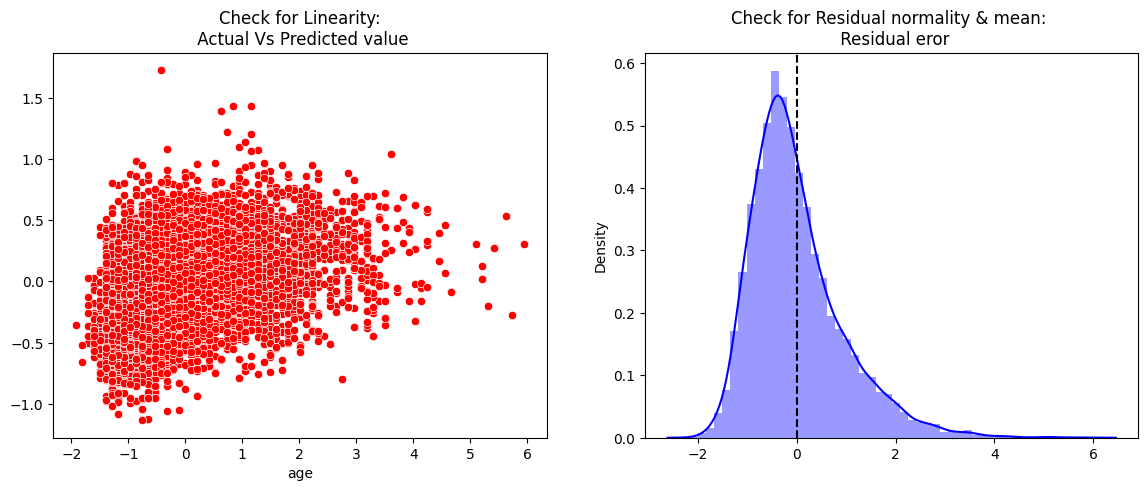

In [102]:
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
y = scn1_df_train_age_pred_y["age"]
sns.scatterplot(y,y_train_pred,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y - y_train_pred),ax=ax,color='b')
ax.axvline((y - y_train_pred).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

In [36]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y - y_train_pred),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y - y_train_pred), x= y_train_pred, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

### Plot Training Data - Actual Ages(orange line) and Predicted Ages(blue line)

In [103]:
r = []
for pair in  zip(y_train_pred[:100], scn1_df_train_age_pred_y['age'].values[:100]):
    r.append(pair)

plt.plot(r)

#### Testing data model validation

In [62]:
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
y = scn1_df_test_age_pred_y["age"]
sns.scatterplot(y,y_pred_test,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y - y_pred_test),ax=ax,color='b')
ax.axvline((y - y_pred_test).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

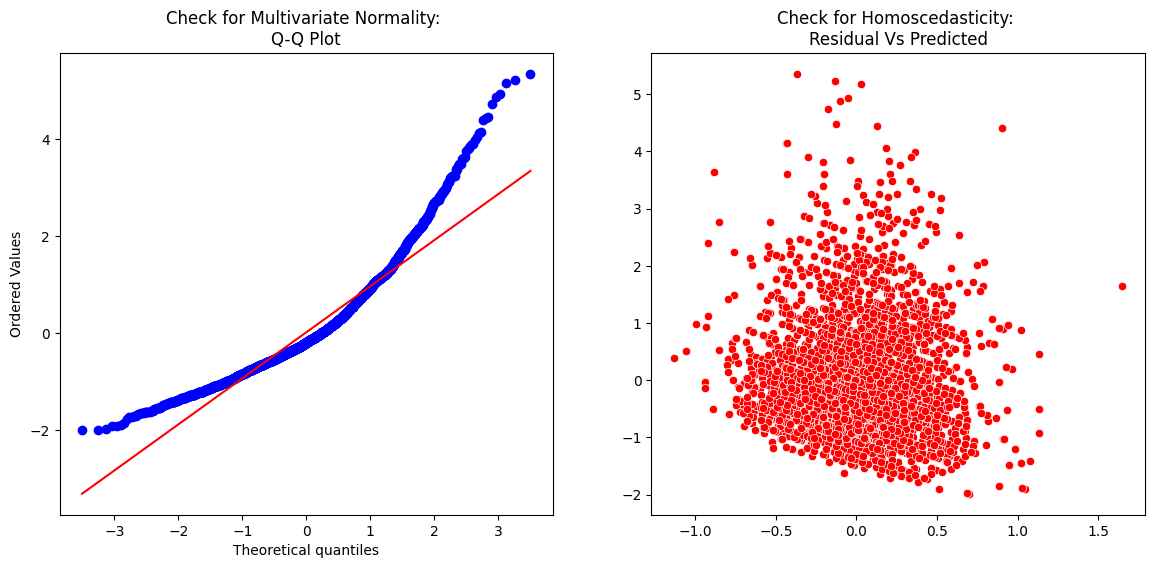

In [63]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y - y_pred_test),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y - y_pred_test), x= y_pred_test, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

### Plot Testing Data - Actual Ages(orange line) and Predicted Ages(blue line)

In [109]:
r = []
for pair in  zip(y_pred_test[:100], scn1_df_test_age_pred_y['age'].values[:100]):
    r.append(pair)

plt.plot(r)

## Age prediction using XG Boost Regressor

In [119]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

In [108]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_by_tree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators': range(60, 360, 40),
        'learning_rate': [0.1, 0.01, 0.05]
 }

In [132]:
X= scn1_df_train_age_pred_x.copy()
Y= scn1_df_train_age_pred_y["age"].values

In [134]:
import xgboost as xgb
 
#X, Y = #Import your data
dmatrix = xgb.DMatrix(data=X, label=Y) #Learning API uses a dmatrix
params = {'objective':'reg:squarederror'}
cv_results = xgb.cv(dtrain=dmatrix, 
                    params=params, 
                    nfold=5, 
                    metrics={'rmse'})
print('RMSE: %.2f' % cv_results['test-rmse-mean'].min())

RMSE: 0.96


In [135]:
import xgboost as xgb
##X, y = # Import your data
#xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
xgbr = xgb.XGBRegressor(objective='reg:squarederror')
xgbr.fit(X, Y)
 
ypred = xgbr.predict(X)
mse = mean_squared_error(Y, ypred)
print("RMSE: %.2f" % (mse**(1/2.0)))

RMSE: 0.91


In [136]:
ypred_test = xgbr.predict(scn1_df_test_age_pred_x)
mse = mean_squared_error(scn1_df_test_age_pred_y, ypred_test)
print("RMSE: %.2f" % (mse**(1/2.0)))

RMSE: 0.98


## Age prediction using Random Forest Regressor

In [202]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

forest_model = RandomForestRegressor(random_state=1001)
forest_model.fit(scn1_df_train_age_pred_x, scn1_df_train_age_pred_y)
melb_preds = forest_model.predict(scn1_df_train_age_pred_x)
print(mean_absolute_error(scn1_df_train_age_pred_y, melb_preds))

0.27434547756300626


In [204]:
#Age Prediction training data - Scenario1 - Actual Age(Orange) vs Predicted Age (Blue))

rf1_train_preds = forest_model.predict(scn1_df_train_age_pred_x)
rf1_test_preds = stackReg1.predict(scn1_df_test_age_pred_x)

r = []
for pair in  zip(rf1_train_preds[:100], scn1_df_train_age_pred_y['age'][:100]):
    r.append(pair)

plt.plot(r)

In [70]:
test_preds = forest_model.predict(scn1_df_test_age_pred_x)
print(mean_absolute_error(scn1_df_test_age_pred_y, test_preds))

0.7499104225494105


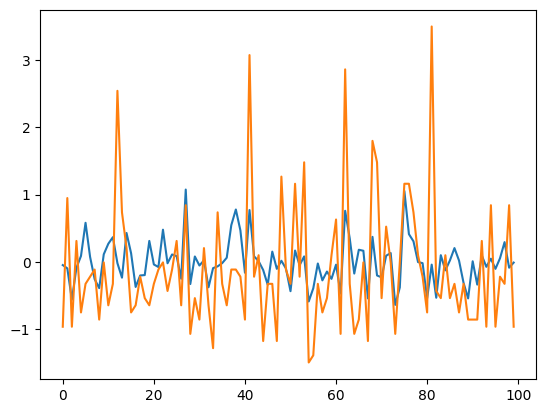

In [205]:
#Age Prediction test data - Scenario1 - Actual Age(Orange) vs Predicted Age (Blue))

r = []
for pair in  zip(rf1_test_preds[:100], scn1_df_test_age_pred_y['age'][:100]):
    r.append(pair)

plt.plot(r)

### Training data model validation

In [72]:
#histogram and normal probability plot
from scipy import stats
from scipy.stats import norm
sns.distplot(scn1_df_train_age_pred_y['age'],fit=norm);
fig = plt.figure()
res = stats.probplot(scn1_df_train_age_pred_y['age'], plot=plt)

### Testing data model validation

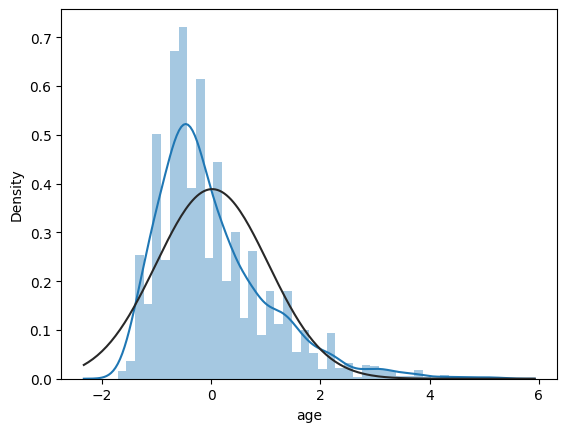

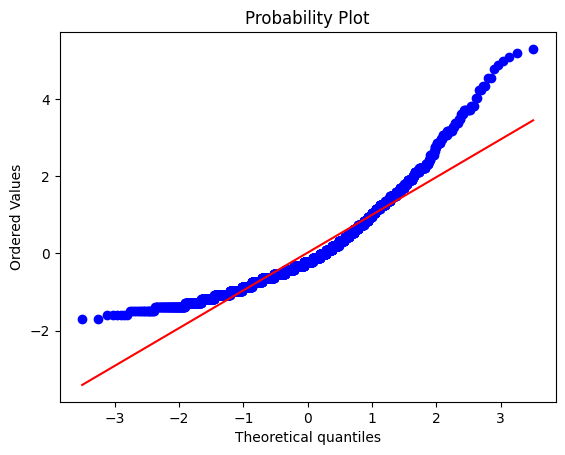

In [73]:
#histogram and normal probability plot
sns.distplot(scn1_df_test_age_pred_y['age'],fit=norm);
fig = plt.figure()
res = stats.probplot(scn1_df_test_age_pred_y['age'], plot=plt)

## Age Prediction using Stacking Regressor Model

In [199]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

X = scn1_df_train_age_pred_x.copy().values
y = scn1_df_train_age_pred_y.copy().values
X_test = scn1_df_test_age_pred_x.copy().values
y_test = scn1_df_test_age_pred_y.copy().values


estimators = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest Regressor', RandomForestRegressor(n_estimators=500, random_state=1001))
]
stackReg1 = StackingRegressor(
    estimators=estimators,
    n_jobs=-1,
    cv=5,
    verbose=10,
    final_estimator=XGBRegressor(random_state=1001, nthread=4, silent=True, learning_rate=0.05,
              n_estimators=180, subsample=0.8, objective='reg:squarederror', 
              min_child_weight=10, max_depth=3,gamma=0.5, eval_metric='rmse', eta=0.5,
              booster='gbtree')
)

stackReg1.fit(X, y).score(X_test, y_test)

[15:45:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



0.07414283956308687

In [200]:
#Age Prediction training data - Scenario1 - Actual Age(Orange) vs Predicted Age (Blue))

stk_reg_y1_train_preds = stackReg1.predict(X)
stk_reg_y1_test_preds = stackReg1.predict(X_test)

r = []
for pair in  zip(stk_reg_y1_train_preds[:100], y[:100]):
    r.append(pair)

plt.plot(r)

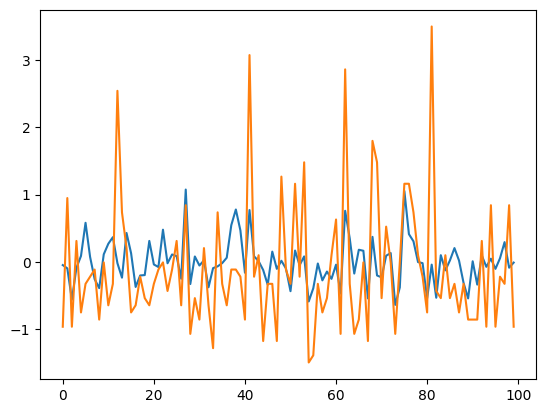

In [201]:
#Age Prediction test data - Scenario1 - Actual Age(Orange) vs Predicted Age (Blue))
r = []
for pair in  zip(stk_reg_y1_test_preds[:100], y_test[:100]):
    r.append(pair)

plt.plot(r)

## Gender Classification using Logistic Regression

In [165]:
from sklearn.linear_model import LogisticRegression


X = scn1_df_train_gender_pred_x.copy().values
y = scn1_df_train_gender_pred_y.copy().values
X_test = scn1_df_test_gender_pred_x.copy().values
y_test = scn1_df_test_gender_pred_y.copy().values

# instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=1001)


# fit the model
logreg.fit(X, y)

LogisticRegression(random_state=1001, solver='liblinear')

In [160]:
def metrics(act,pred):
    print('Accuracy : ',accuracy_score(act,pred))
    print()
    print('Confusion Matrix : ') 
    print(confusion_matrix(act,pred))
    print()
    precision, recall, fscore, support = precision_recall_fscore_support(act,pred)
    print("Precision : ", precision)
    print("Recall : ", recall)
    print("F1-Score : ", fscore)
    print()

In [166]:
y_preds = logreg.predict(X)
Y = scn1_df_train_gender_pred_y["gender"].values

log_reg_train_output_df =  pd.DataFrame(data={'actual_gender':Y, 'predicted_gender':y_preds})
log_reg_train_output_df

actual_gender  predicted_gender
0                 0                 0
1                 1                 0
2                 0                 0
3                 0                 0
4                 1                 0
...             ...               ...
8902              0                 0
8903              0                 0
8904              0                 0
8905              0                 0
8906              0                 0

[8907 rows x 2 columns]

In [36]:
y_preds = logreg.predict(X)
Y = scn1_df_train_gender_pred_y["gender"].values

log_reg_train_output_df =  pd.DataFrame(data={'actual_gender':Y, 'predicted_gender':y_preds})
log_reg_train_output_df

actual_gender  predicted_gender
0                 0                 0
1                 1                 0
2                 0                 0
3                 0                 0
4                 1                 0
...             ...               ...
8902              0                 0
8903              0                 0
8904              0                 0
8905              0                 0
8906              0                 0

[8907 rows x 2 columns]

In [37]:
y_test_preds = logreg.predict(scn1_df_test_gender_pred_x)

log_reg_test_output_df =  pd.DataFrame(data={'actual_gender':scn1_df_test_gender_pred_y["gender"], 'predicted_gender':y_test_preds})
log_reg_test_output_df.head()

actual_gender  predicted_gender
0              0                 0
1              0                 0
2              0                 1
3              0                 0
4              0                 0

In [41]:
from sklearn.metrics import accuracy_score

print('Model accuracy score for Train data: {0:0.4f}'. format(accuracy_score(Y, y_preds)))
print('Model accuracy score for Test data: {0:0.4f}'. format(accuracy_score(scn1_df_test_gender_pred_y["gender"], y_test_preds)))

Model accuracy score for Train data: 0.7138
Model accuracy score for Test data: 0.7212


In [156]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

def metrics(act,pred):
    print('Accuracy : ',accuracy_score(act,pred))
    print()
    print('Confusion Matrix : ') 
    print(confusion_matrix(act,pred))
    print()
    precision, recall, fscore, support = precision_recall_fscore_support(act,pred)
    print("Precision : ", precision)
    print("Recall : ", recall)
    print("F1-Score : ", fscore)
    print()


In [46]:
metrics(y_preds,scn1_df_train_gender_pred_y["gender"])

Accuracy :  0.713820590546761

Confusion Matrix : 
[[6019 2303]
 [ 246  339]]

Precision :  [0.96073424 0.12831188]
Recall :  [0.72326364 0.57948718]
F1-Score :  [0.82525536 0.21010226]



In [117]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y, y_preds)

print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])


cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

Confusion matrix

 [[6019  246]
 [2303  339]]

True Positives(TP) =  6019

True Negatives(TN) =  339

False Positives(FP) =  246

False Negatives(FN) =  2303


<AxesSubplot: >

In [47]:
print('Model accuracy score for Train data: {0:0.4f}'. format(logreg.score(scn1_df_train_gender_pred_x, scn1_df_train_gender_pred_y["gender"])))
print('Model accuracy score for Test data: {0:0.4f}'. format(logreg.score(scn1_df_test_gender_pred_x, scn1_df_test_gender_pred_y["gender"])))

Model accuracy score for Train data: 0.7138
Model accuracy score for Test data: 0.7212


Text(0.5, 0, 'False Positive Rate')

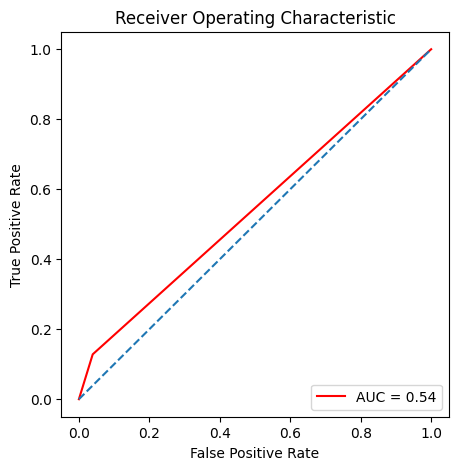

In [167]:
from sklearn.metrics import roc_curve

X = scn1_df_train_gender_pred_x.copy().values
y = scn1_df_train_gender_pred_y.copy().values
X_test = scn1_df_test_gender_pred_x.copy().values
y_test = scn1_df_test_gender_pred_y.copy().values

roc_curve(y, y_preds)

y_preds_proba = logreg.predict_proba(X)
y_preds_proba

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_preds)
train_roc_auc = auc(false_positive_rate, true_positive_rate)
train_roc_auc


import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % train_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Gender Classification using XG Boost Classifier

In [57]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [58]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


Y = scn1_df_train_gender_pred_y["gender"].values
X = scn1_df_train_gender_pred_x.copy()

In [59]:
xgb = XGBClassifier(n_estimators=500, objective='binary:logistic',
                    silent=True, nthread=1)

In [60]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    silent=True
)

In [62]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_by_tree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators': range(60, 360, 40),
        'learning_rate': [0.1, 0.01, 0.05]
 }

In [63]:
folds = 5
param_comb = 100

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(estimator, param_distributions=params, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=skf.split(X,Y), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 100 candidates, totalling 500 fits

 Time taken: 0 hours 47 minutes and 37.03 seconds.


In [65]:
print(random_search.best_score_)
print(random_search.best_params_)
print(random_search.best_estimator_)

0.6547070364458631
{'subsample': 0.6, 'n_estimators': 180, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 1.5, 'colsample_by_tree': 1.0}
XGBClassifier(colsample_by_tree=1.0, gamma=1.5, learning_rate=0.05,
              n_estimators=180, nthread=4, silent=True, subsample=0.6)


In [66]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([14.69435635,  8.34629536, 11.43221731,  5.23645878, 10.53478961,
       14.25735283, 18.32549486, 14.36669221, 22.01805511,  9.95126495,
       13.78111048, 14.94953327,  6.52849283, 19.36534333,  7.3098248 ,
        4.86601491,  3.57900124,  8.32923565,  3.56022091,  3.58339677,
        8.07107358, 17.11294475, 21.80541177,  6.33417182,  8.24387255,
        6.76764946, 15.44694991,  3.0498775 , 19.77053785,  8.10957723,
       21.19974775,  6.84291101,  6.05795636, 16.99955907,  4.02288966,
       11.73642197, 24.3384388 ,  9.23501282, 16.19598455,  2.78497572,
        9.08697138, 11.19028397,  9.47173948,  3.80148273, 27.51857686,
        7.00263481, 24.05508952,  6.60584993,  7.22871766, 22.14606996,
       15.39320073,  3.62165337,  4.0059442 , 19.66128874, 17.19991465,
       19.44314194,  8.1361608 , 12.56915784,  5.93347664,  6.62211213,
       13.40798998, 10.68808427, 15.5976449 , 20.10933414,  8.32250485,
       19.53663368,  8.74334865

In [67]:
xgb_gender_preds = random_search.predict_proba(scn1_df_train_gender_pred_x)
xgb_gender_pred_scn1_df = pd.DataFrame(data={'actual':scn1_df_train_gender_pred_y['gender'], 'predicted':xgb_gender_preds[:,1]})
xgb_gender_pred_scn1_df.to_csv('xgb_train_gender_classification_scn1_df.csv', index=False)
xgb_gender_pred_scn1_df.head()

actual  predicted
0       0   0.195113
1       1   0.293479
2       0   0.303824
3       0   0.338209
4       1   0.345594

In [68]:
y_test = random_search.predict_proba(scn1_df_test_gender_pred_x)
xgb_test_gender_df = pd.DataFrame(data={'actual':scn1_df_test_gender_pred_y['gender'], 'predicted':y_test[:,1]})
xgb_test_gender_df.to_csv('xgb_test_gender_classification_scn1_df.csv', index=False)
xgb_test_gender_df.head()

actual  predicted
0       0   0.221306
1       0   0.118922
2       0   0.537167
3       0   0.111087
4       0   0.185192

In [69]:
pickle.dump(estimator,open('xgb_gender_classification_scn1.pkl','wb'))

## Gender Classification using Random Forest

In [135]:
from sklearn.ensemble import RandomForestClassifier

In [144]:
rfc = RandomForestClassifier(n_estimators=500, random_state=1001, oob_score=True)

In [145]:
rfc.fit(scn1_df_train_gender_pred_x,scn1_df_train_gender_pred_y)

RandomForestClassifier(n_estimators=500, oob_score=True, random_state=1001)

In [51]:
rfc.oob_score_

0.7062984169754126

In [153]:
y1_rfc_preds=rfc.predict(scn1_df_train_gender_pred_x)
y1_rfc_preds

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [146]:
rfc_pred=rfc.predict(scn1_df_test_gender_pred_x)
rfc_pred

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

In [53]:
metrics(rfc_pred,scn1_df_test_gender_pred_y)

Accuracy :  0.727810650887574

Confusion Matrix : 
[[2095  737]
 [  91  119]]

Precision :  [0.95837145 0.13901869]
Recall :  [0.73975989 0.56666667]
F1-Score :  [0.83499402 0.22326454]



Confusion matrix

 [[2095   91]
 [ 737  119]]

True Positives(TP) =  2095

True Negatives(TN) =  119

False Positives(FP) =  91

False Negatives(FN) =  737


<AxesSubplot: >

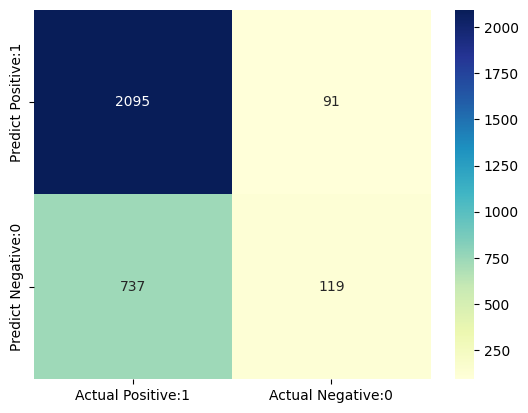

In [141]:
rfc_cm = confusion_matrix(scn1_df_test_gender_pred_y, rfc_pred)

print('Confusion matrix\n\n', rfc_cm)
print('\nTrue Positives(TP) = ', rfc_cm[0,0])
print('\nTrue Negatives(TN) = ', rfc_cm[1,1])
print('\nFalse Positives(FP) = ', rfc_cm[0,1])
print('\nFalse Negatives(FN) = ', rfc_cm[1,0])


rfc_cm_matrix = pd.DataFrame(data=rfc_cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(rfc_cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

Text(0.5, 0, 'False Positive Rate')

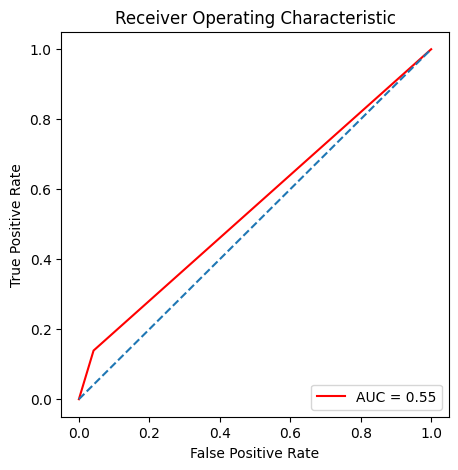

In [164]:
from sklearn.metrics import roc_curve

X = scn1_df_train_gender_pred_x.copy().values
y = scn1_df_train_gender_pred_y.copy().values
X_test = scn1_df_test_gender_pred_x.copy().values
y_test = scn1_df_test_gender_pred_y.copy().values

roc_curve(scn1_df_test_gender_pred_y, rfc_pred)

y_preds_proba = rfc.predict_proba(X)
y_preds_proba

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(scn1_df_test_gender_pred_y, rfc_pred)
train_roc_auc = auc(false_positive_rate, true_positive_rate)
train_roc_auc


import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % train_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [54]:
pickle.dump(rfc,open('rf_gender_classification_scn1.pkl','wb'))

## Gender Classification using Stacking Classifier Model

In [72]:
!pip3 install xgboost
from xgboost import XGBClassifier,XGBRegressor

from sklearn.ensemble import StackingClassifier

X = scn1_df_train_gender_pred_x.copy().values
y = scn1_df_train_gender_pred_y.copy().values
X_test = scn1_df_test_gender_pred_x.copy().values
y_test = scn1_df_test_gender_pred_y.copy().values

estimators = [
    ('Logistic Regression', logreg),
    ('Random Forest Classifier', rfc)
]
stackCls = StackingClassifier(
    estimators=estimators,
    n_jobs=-1,
    cv=5,
    verbose=10,
    final_estimator=XGBClassifier(random_state=1001, objective= 'binary:logistic', nthread=4, silent=True, colsample_by_tree=1.0, gamma=1.5, learning_rate=0.05,
              n_estimators=180, subsample=0.6)
)

stackCls.fit(X, y).score(X_test, y_test)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


0.7209072978303748

In [127]:
stackCls_y_preds = stackCls.predict(X)

Confusion matrix

 [[6242   23]
 [2387  255]]

True Positives(TP) =  6242

True Negatives(TN) =  255

False Positives(FP) =  23

False Negatives(FN) =  2387


<AxesSubplot: >

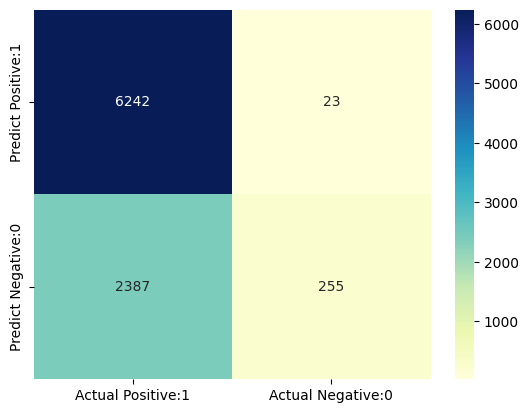

In [142]:
stackCls_cm = confusion_matrix(y, stackCls_y_preds)

print('Confusion matrix\n\n', stackCls_cm)
print('\nTrue Positives(TP) = ', stackCls_cm[0,0])
print('\nTrue Negatives(TN) = ', stackCls_cm[1,1])
print('\nFalse Positives(FP) = ', stackCls_cm[0,1])
print('\nFalse Negatives(FN) = ', stackCls_cm[1,0])


stackCls_cm_matrix = pd.DataFrame(data=stackCls_cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(stackCls_cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

Text(0.5, 0, 'False Positive Rate')

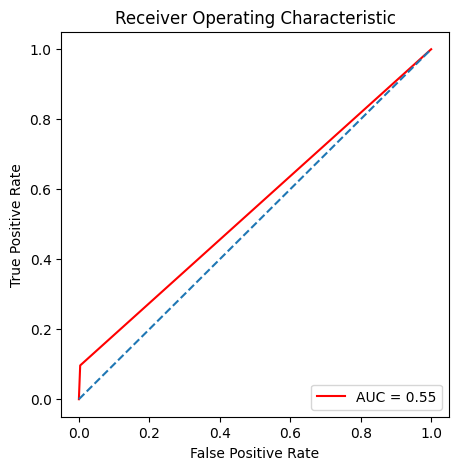

In [130]:
from sklearn.metrics import roc_curve

roc_curve(y, stackCls_y_preds)

y_preds_proba = logreg.predict_proba(X)
y_preds_proba

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y, stackCls_y_preds)
train_roc_auc = auc(false_positive_rate, true_positive_rate)
train_roc_auc


import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % train_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Modeling for Scenario 2

## Age Prediction using Linear Regression

In [64]:
# Add a constant to get an intercept
X_train_sm = sm.add_constant(scn2_df_train_age_pred_x)

# Fit the resgression line using 'OLS'
lr = sm.OLS(scn2_df_train_age_pred_y, X_train_sm).fit()

In [95]:
lr.params

const                             -0.067613
gender                             0.058042
device_best_hourcat_Late Night    -0.113021
phone_brand_shrunk_Coolpad         0.272917
phone_brand_shrunk_Gionee          0.057781
                                     ...   
device_model_shrunk_é’æ˜¥ç‰ˆ     -0.012073
device_model_shrunk_é­…è“        -0.144681
device_model_shrunk_é­…è“2       -0.570220
device_model_shrunk_é­…è“metal   -0.746352
device_model_shrunk_éº¦èŠ’4        0.055930
Length: 132, dtype: float64

In [94]:
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     4.454
Date:                Thu, 26 Jan 2023   Prob (F-statistic):           4.13e-55
Time:                        17:15:22   Log-Likelihood:                -12273.
No. Observations:                8907   AIC:                         2.481e+04
Df Residuals:                    8777   BIC:                         2.573e+04
Df Model:                         129                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [65]:
y_train_pred = lr.predict(X_train_sm)
res = (scn2_df_train_age_pred_y - y_train_pred)

In [100]:
#Returns the mean squared error; we'll take a square root
print(np.sqrt(mean_squared_error(scn2_df_train_age_pred_y, y_train_pred)))

r_squared = r2_score(scn2_df_train_age_pred_y, y_train_pred)
print(r_squared)

0.9597712882809526
0.06143869217760556


In [66]:
X_test_sm = sm.add_constant(scn2_df_test_age_pred_x)

# Predict the y values corresponding to X_test_sm
y_pred_test = lr.predict(X_test_sm)
y_pred_test.head()

0    0.095856
1   -0.133369
2   -0.592394
3   -0.187998
4    0.136274
dtype: float64

In [101]:
#Returns the mean squared error; we'll take a square root
print(np.sqrt(mean_squared_error(scn2_df_test_age_pred_y, y_pred_test)))

r_squared = r2_score(scn1_df_test_age_pred_y, y_pred_test)
print(r_squared)

1.0110324180276329
0.02987596398077652


In [39]:
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
y = scn2_df_train_age_pred_y["age"]
sns.scatterplot(y,y_train_pred,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y - y_train_pred),ax=ax,color='b')
ax.axvline((y - y_train_pred).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

In [40]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y - y_train_pred),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y - y_train_pred), x= y_train_pred, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

In [67]:
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
y = scn2_df_test_age_pred_y["age"]
sns.scatterplot(y,y_pred_test,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y - y_pred_test),ax=ax,color='b')
ax.axvline((y - y_train_pred).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

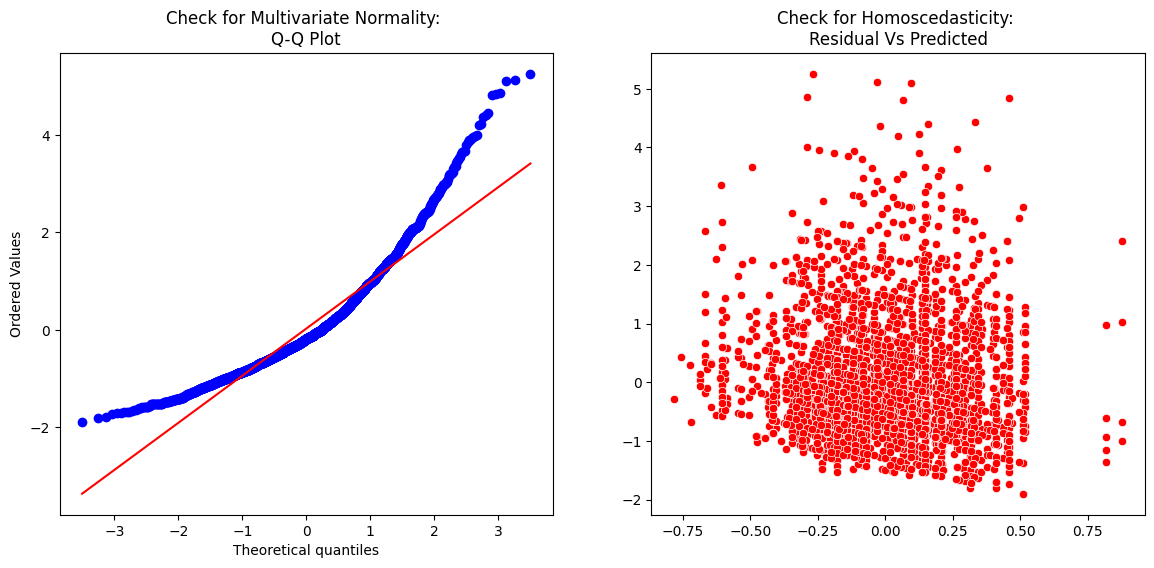

In [68]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y - y_pred_test),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y - y_pred_test), x= y_pred_test, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

## Age Prediction using Random Forest

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(scn2_df_train_age_pred_x, scn2_df_train_age_pred_y)
melb_preds = forest_model.predict(scn2_df_train_age_pred_x)
print(mean_absolute_error(scn2_df_train_age_pred_y, melb_preds))

0.71956519836722


In [75]:
test_preds = forest_model.predict(scn2_df_test_age_pred_x)
print(mean_absolute_error(scn2_df_test_age_pred_y, test_preds))

0.7669662902520733


### Training Data Model validation

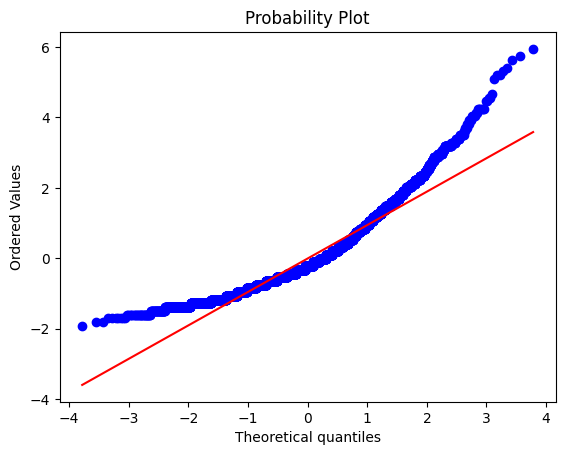

In [76]:
#histogram and normal probability plot
sns.distplot(scn2_df_train_age_pred_y['age'],fit=norm);
fig = plt.figure()
res = stats.probplot(scn2_df_train_age_pred_y['age'], plot=plt)

### Plot Training Data - Actual Ages(orange line) and Predicted Ages(blue line)

In [88]:
for z in zip(scn2_df_train_age_pred_y['age'].values, melb_preds):
    print(z, (z[0]-z[1]) /z[0] )

(0.4165891365947717, 0.2691659685146913) 0.35388145088258305
(-0.1149343325431992, -0.09429121532410863) 0.17960792708594406
(0.8418079119051485, 0.22746553996684493) 0.7297892586302102
(-1.4968953523019235, -0.10652045133905834) 0.9288390793817007
(-0.9653718831639528, -0.2566410654103337) 0.7341531591232937
(-1.2842859646467353, 0.19158175761145035) 1.1491737532646387
(1.2670266872155251, -0.22671438175871544) 1.1789341803501812
(0.9481126057327426, 0.19158175761145035) 0.7979335403273247
(-0.5401531078535761, -0.18855390246823472) 0.6509250808210704
(-0.1149343325431992, 0.11031857464456964) 1.959840042600894
(-0.8590671893363586, -0.30267950648977476) 0.6476649204544771
(-0.8590671893363586, 0.20673824984619066) 1.2406543427713714
(0.0976750551119891, 0.3570815548231537) -2.655811142504529
(-0.6464578016811702, -0.253880672820379) 0.6072741760403539
(0.3102844427671775, 0.16555968093525145) 0.4664260977483829
(-1.177981270819141, -0.0997742818413206) 0.9153006212297927
(-0.11493433

In [87]:
type( scn2_df_train_age_pred_y['age'].values)

numpy.ndarray

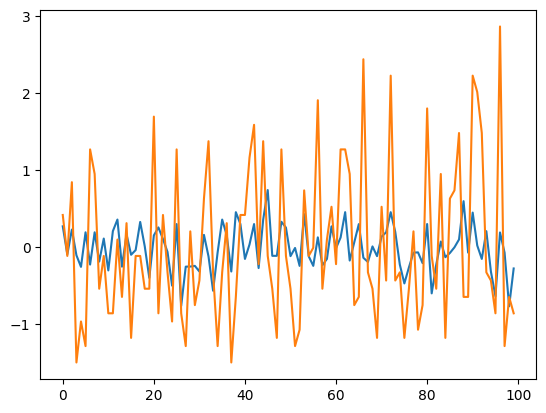

In [97]:
r = []
for pair in  zip(melb_preds[:100], scn2_df_train_age_pred_y['age'].values[:100]):
    r.append(pair)

plt.plot(r)

### Testing Data Model Validation

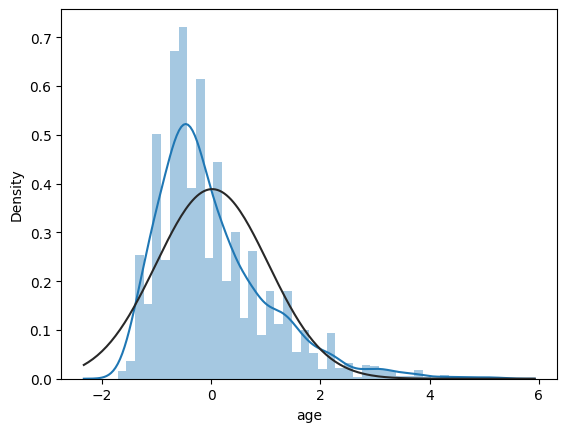

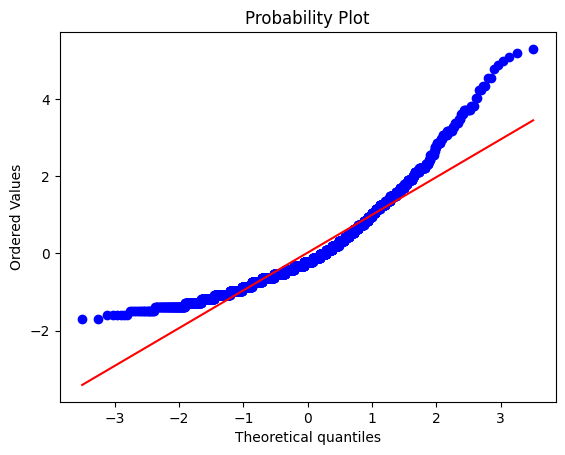

In [77]:
#histogram and normal probability plot
sns.distplot(scn2_df_test_age_pred_y['age'],fit=norm);
fig = plt.figure()
res = stats.probplot(scn2_df_test_age_pred_y['age'], plot=plt)

### Plot Testing Data - Actual Ages(orange line) and Predicted Ages(blue line)

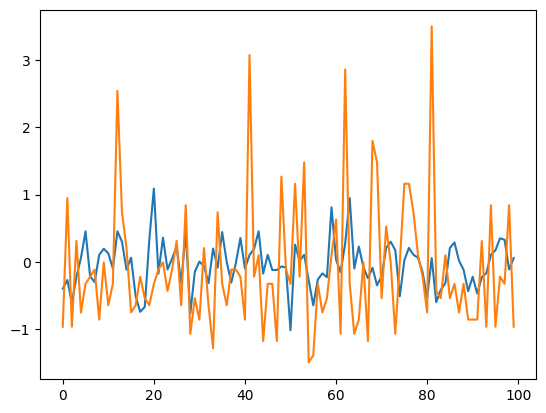

In [98]:
r = []
for pair in  zip(test_preds[:100], scn2_df_test_age_pred_y['age'].values[:100]):
    r.append(pair)

plt.plot(r)

## Age Prediction using XG Boost Regressor

In [137]:
X= scn2_df_train_age_pred_x.copy()
Y= scn2_df_train_age_pred_y["age"].values

In [138]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_by_tree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators': range(60, 360, 40),
        'learning_rate': [0.1, 0.01, 0.05]
 }

In [139]:
import xgboost as xgb
 
#X, Y = #Import your data
dmatrix = xgb.DMatrix(data=X, label=Y) #Learning API uses a dmatrix
params = {'objective':'reg:squarederror'}
cv_results = xgb.cv(dtrain=dmatrix, 
                    params=params, 
                    nfold=5, 
                    metrics={'rmse'})
print('RMSE: %.2f' % cv_results['test-rmse-mean'].min())

RMSE: 0.97


In [140]:
import xgboost as xgb
##X, y = # Import your data
#xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
xgbr = xgb.XGBRegressor(objective='reg:squarederror')
xgbr.fit(X, Y)
 
ypred = xgbr.predict(X)
mse = mean_squared_error(Y, ypred)
print("RMSE: %.2f" % (mse**(1/2.0)))

RMSE: 0.96


In [141]:
ypred_test = xgbr.predict(scn2_df_test_age_pred_x)
mse = mean_squared_error(scn2_df_test_age_pred_y, ypred_test)
print("RMSE: %.2f" % (mse**(1/2.0)))

RMSE: 1.01


## Age Prediction Stacked Regressor Model

In [78]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

X = scn2_df_train_age_pred_x.copy().values
y = scn2_df_train_age_pred_y.copy().values
X_test = scn2_df_test_age_pred_x.copy().values
y_test = scn2_df_test_age_pred_y.copy().values


estimators = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest Regressor', RandomForestRegressor(n_estimators=500, random_state=1001))
]
stackReg = StackingRegressor(
    estimators=estimators,
    n_jobs=-1,
    cv=5,
    verbose=10,
    final_estimator=XGBRegressor(random_state=1001, nthread=4, silent=True, learning_rate=0.05,
              n_estimators=180, subsample=0.8, objective='reg:squarederror', 
              min_child_weight=10, max_depth=3,gamma=0.5, eval_metric='rmse', eta=0.5,
              booster='gbtree')
)

stackReg.fit(X, y).score(X_test, y_test)

[16:59:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



0.024155897128579795

In [191]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

X = scn2_df_train_age_pred_x.copy().values
y = scn2_df_train_age_pred_y.copy().values
X_test = scn2_df_test_age_pred_x.copy().values
y_test = scn2_df_test_age_pred_y.copy().values


estimators = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest Regressor', RandomForestRegressor(n_estimators=500, random_state=1001))
]
stackReg = StackingRegressor(
    estimators=estimators,
    n_jobs=-1,
    cv=5,
    verbose=10,
    final_estimator=XGBRegressor(random_state=1001, nthread=4, silent=True, learning_rate=0.05,
              n_estimators=180, subsample=0.8, objective='reg:squarederror', 
              min_child_weight=10, max_depth=3,gamma=0.5, eval_metric='rmse', eta=0.5,
              booster='gbtree')
)

stackReg.fit(X, y).score(X_test, y_test)

[15:35:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



0.024155897128579795

In [197]:
stk_reg_y2_train_preds = stackReg.predict(X)
stk_reg_y2_test_preds = stackReg.predict(X_test)

In [196]:
#Age Prediction training data - Scenario2 - Actual Age(Orange) vs Predicted Age (Blue))

r = []
for pair in  zip(stk_reg_y2_train_preds[:100], y[:100]):
    r.append(pair)

plt.plot(r)

In [198]:
#Age Prediction test data - Scenario2 - Actual Age(Orange) vs Predicted Age (Blue))
r = []
for pair in  zip(stk_reg_y2_test_preds[:100], y_test[:100]):
    r.append(pair)

plt.plot(r)

## Gender Classification using Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression


X = scn2_df_train_gender_pred_x.copy().values
y = scn2_df_train_gender_pred_y.copy().values
X_test = scn2_df_test_gender_pred_x.copy().values
y_test = scn2_df_test_gender_pred_y.copy().values

# instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=1001)


# fit the model
logreg.fit(X, y)

LogisticRegression(random_state=1001, solver='liblinear')

In [63]:
y_preds = logreg.predict(X)
Y = scn2_df_train_gender_pred_y["gender"].values

log_reg_train_output_df =  pd.DataFrame(data={'actual_gender':Y, 'predicted_gender':y_preds})
log_reg_train_output_df

actual_gender  predicted_gender
0                 0                 0
1                 1                 0
2                 0                 0
3                 0                 0
4                 1                 0
...             ...               ...
8902              0                 0
8903              0                 0
8904              0                 0
8905              0                 0
8906              0                 0

[8907 rows x 2 columns]

In [48]:
logreg.predict_proba(X)[:,0]

array([0.58223184, 0.59295823, 0.76142927, ..., 0.74684919, 0.7543673 ,
       0.82095381])

In [51]:
logreg.predict_proba(X)[:,1]

array([0.41776816, 0.40704177, 0.23857073, ..., 0.25315081, 0.2456327 ,
       0.17904619])

In [64]:
y_test_preds = logreg.predict(scn2_df_test_gender_pred_x)

log_reg_test_output_df =  pd.DataFrame(data={'actual_gender':scn2_df_test_gender_pred_y["gender"], 'predicted_gender':y_test_preds})
log_reg_test_output_df.head()

actual_gender  predicted_gender
0              0                 0
1              0                 0
2              0                 1
3              0                 0
4              0                 0

In [50]:
logreg.predict_proba(scn2_df_test_gender_pred_x)[:,0]

array([0.81413897, 0.85596155, 0.47675976, ..., 0.86973535, 0.67058961,
       0.60315963])

In [52]:
logreg.predict_proba(scn2_df_test_gender_pred_x)[:,1]

array([0.18586103, 0.14403845, 0.52324024, ..., 0.13026465, 0.32941039,
       0.39684037])

In [65]:
from sklearn.metrics import accuracy_score

print('Model accuracy score for Train data: {0:0.4f}'. format(accuracy_score(Y, y_preds)))
print('Model accuracy score for Test data: {0:0.4f}'. format(accuracy_score(scn2_df_test_gender_pred_y["gender"], y_test_preds)))

Model accuracy score for Train data: 0.7063
Model accuracy score for Test data: 0.7163


In [56]:
# fit the Logsitic Regression model with C=100

# instantiate the model
logreg100 = LogisticRegression(C=100, solver='liblinear', random_state=0)


# fit the model
logreg100.fit(X, Y)

LogisticRegression(C=100, random_state=0, solver='liblinear')

In [61]:
print('Model accuracy score for Train data: {0:0.4f}'. format(logreg100.score(X, Y)))
print('Model accuracy score for Test data: {0:0.4f}'. format(logreg100.score(scn2_df_test_gender_pred_x, scn2_df_test_gender_pred_y["gender"])))

Model accuracy score for Train data: 0.7066
Model accuracy score for Test data: 0.7153


In [62]:
# fit the Logsitic Regression model with C=0.01

# instantiate the model
logreg001 = LogisticRegression(C=0.01, solver='liblinear', random_state=0)


# fit the model
logreg001.fit(X, Y)

LogisticRegression(C=0.01, random_state=0, solver='liblinear')

In [63]:
print('Model accuracy score for Train data: {0:0.4f}'. format(logreg001.score(X, Y)))
print('Model accuracy score for Test data: {0:0.4f}'. format(logreg001.score(scn2_df_test_gender_pred_x, scn2_df_test_gender_pred_y["gender"])))

Model accuracy score for Train data: 0.7034
Model accuracy score for Test data: 0.7186


In [70]:
scn2_df_test_gender_pred_y[scn2_df_test_gender_pred_y["gender"]==0].value_counts()[0]

2186

In [74]:
scn2_df_test_gender_pred_y["gender"].value_counts().sum()

3042

In [75]:

null_accuracy = (scn2_df_test_gender_pred_y[scn2_df_test_gender_pred_y["gender"]==0].value_counts()[0]/(scn2_df_test_gender_pred_y["gender"].value_counts().sum()))

print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.7186


In [76]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y, y_preds)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) = ', cm[0,1])

print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[6196   69]
 [2547   95]]

True Positives(TP) =  6196

True Negatives(TN) =  95

False Positives(FP) =  69

False Negatives(FN) =  2547


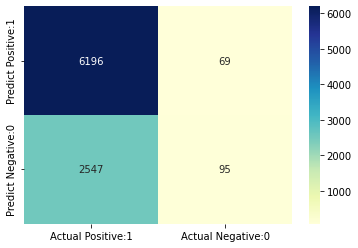

In [79]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [81]:
from sklearn.metrics import classification_report

print(classification_report(scn2_df_test_gender_pred_y["gender"], y_test_preds))

              precision    recall  f1-score   support

           0       0.72      0.99      0.83      2186
           1       0.43      0.02      0.04       856

    accuracy                           0.72      3042
   macro avg       0.57      0.51      0.44      3042
weighted avg       0.64      0.72      0.61      3042



In [83]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

Classification accuracy : 0.7063


In [84]:
# print classification error

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))

Classification error : 0.2937


In [85]:
# print precision score

precision = TP / float(TP + FP)


print('Precision : {0:0.4f}'.format(precision))

Precision : 0.9890


In [86]:
recall = TP / float(TP + FN)

print('Recall or Sensitivity : {0:0.4f}'.format(recall))

Recall or Sensitivity : 0.7087


In [87]:
true_positive_rate = TP / float(TP + FN)


print('True Positive Rate : {0:0.4f}'.format(true_positive_rate))

True Positive Rate : 0.7087


In [88]:
false_positive_rate = FP / float(FP + TN)


print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))

False Positive Rate : 0.4207


In [89]:
specificity = TN / (TN + FP)

print('Specificity : {0:0.4f}'.format(specificity))

Specificity : 0.5793


In [91]:
y_pred_prob = logreg.predict_proba(scn2_df_test_gender_pred_x)[0:10]
y_pred_prob

array([[0.81413897, 0.18586103],
       [0.85596155, 0.14403845],
       [0.47675976, 0.52324024],
       [0.8224037 , 0.1775963 ],
       [0.76603714, 0.23396286],
       [0.76173337, 0.23826663],
       [0.60155626, 0.39844374],
       [0.65999023, 0.34000977],
       [0.75255183, 0.24744817],
       [0.71109433, 0.28890567]])

In [95]:
y_pred_prob_df = pd.DataFrame(data=y_pred_prob, columns=['Prob of - being Male (0)', 'Prob of - being Female (1)'])
y_pred_prob_df

Prob of - being  (0)  Prob of - being  (1)
0              0.814139              0.185861
1              0.855962              0.144038
2              0.476760              0.523240
3              0.822404              0.177596
4              0.766037              0.233963
5              0.761733              0.238267
6              0.601556              0.398444
7              0.659990              0.340010
8              0.752552              0.247448
9              0.711094              0.288906

In [96]:
logreg.predict_proba(scn2_df_test_gender_pred_x)[0:10, 1]

array([0.18586103, 0.14403845, 0.52324024, 0.1775963 , 0.23396286,
       0.23826663, 0.39844374, 0.34000977, 0.24744817, 0.28890567])

In [97]:
# store the predicted probabilities for class 1 - Probability of Female

y_pred1 = logreg.predict_proba(scn2_df_test_gender_pred_x)[:, 1]

In [99]:
# plot histogram of predicted probabilities

# adjust the font size 
plt.rcParams['font.size'] = 12

# plot histogram with 10 bins
plt.hist(y_pred1, bins = 10)

# set the title of predicted probabilities
plt.title('Histogram of predicted probabilities of Gender')

# set the x-axis limit
plt.xlim(0,1)

# set the title
plt.xlabel('Predicted probabilities of Gender')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

In [92]:
log_reg_test_output_df.head(10)

actual_gender  predicted_gender
0              0                 0
1              0                 0
2              0                 1
3              0                 0
4              0                 0
5              0                 0
6              0                 0
7              0                 0
8              1                 0
9              0                 0

In [111]:
from sklearn.preprocessing import binarize
y_pred1 = logreg.predict_proba(scn2_df_test_gender_pred_x)[:,1]
y_pred1 = y_pred1.reshape(-1,1)
y_pred2 = binarize (y_pred1)
y_pred2 = np.where(y_pred2 == 1, 'Yes', 'No')
scn2_df_test_gender_pred_y["gender"]

0       0
1       0
2       0
3       0
4       0
       ..
3037    0
3038    0
3039    0
3040    1
3041    1
Name: gender, Length: 3042, dtype: int64

In [ ]:
confusion_matrix(scn2_df_test_gender_pred_y["gender"], y_pred2)
confusion_matrix(Y, y_preds)

In [116]:
from sklearn.metrics import roc_curve

roc_curve(Y, y_preds)

(array([0.        , 0.01101357, 1.        ]),
 array([0.        , 0.03595761, 1.        ]),
 array([2, 1, 0]))

In [130]:
y_preds_proba = logreg.predict_proba(X)
y_preds_proba

array([[0.58223184, 0.41776816],
       [0.59295823, 0.40704177],
       [0.76142927, 0.23857073],
       ...,
       [0.74684919, 0.25315081],
       [0.7543673 , 0.2456327 ],
       [0.82095381, 0.17904619]])

In [136]:
y_preds

array([0, 0, 0, ..., 0, 0, 0])

In [141]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y, y_preds)
train_roc_auc = auc(false_positive_rate, true_positive_rate)
train_roc_auc

0.5124720202173376

Text(0.5, 0, 'False Positive Rate')

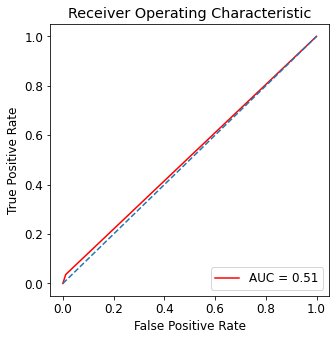

In [146]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % train_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

LR_model= LogisticRegression()

tuned_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] ,
              'penalty':['l1','l2']
                   }

In [149]:
from sklearn.model_selection import GridSearchCV

LR= GridSearchCV(LR_model, tuned_parameters,cv=10)
LR.fit(X,Y)
print(LR.best_params_)

{'C': 1, 'penalty': 'l2'}


In [152]:
X_test = scn2_df_test_gender_pred_x.copy()
Y_test = scn2_df_test_gender_pred_y.copy()

In [182]:
y_test_prob = LR.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_test_pred = np.where(y_test_prob > 0.4, 1, 0) # This will threshold the probabilities to give class predictions.
LR.score(X_test, y_test_pred)

0.8925049309664694

In [183]:
confusion_matrix=metrics.confusion_matrix(Y_test,y_test_pred)
print(confusion_matrix)
auc_roc=metrics.classification_report(Y_test,y_test_pred)
print(auc_roc)
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test,y_test_pred)
test_roc_auc = auc(false_positive_rate, true_positive_rate)
print(test_roc_auc)
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % test_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

[[1956  230]
 [ 712  144]]
              precision    recall  f1-score   support

           0       0.73      0.89      0.81      2186
           1       0.39      0.17      0.23       856

    accuracy                           0.69      3042
   macro avg       0.56      0.53      0.52      3042
weighted avg       0.64      0.69      0.65      3042

0.5315046472454276


Text(0.5, 0, 'False Positive Rate')

In [171]:
LR_ridge= LogisticRegression(penalty='l2')
LR_ridge.fit(X,Y)

LogisticRegression()

In [180]:
y_test_prob = LR.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_test_pred = np.where(y_test_prob > 0.4, 1, 0) # This will threshold the probabilities to give class predictions.
LR_ridge.score(X_test, y_test_pred)

0.8925049309664694

In [186]:
LR_ridge.predict(X)

array([0, 0, 0, ..., 0, 0, 0])

In [188]:
lr_ridge_train_output_gender_df = pd.DataFrame(data={'actual':Y, 'predicted':LR_ridge.predict(X)})
lr_ridge_train_output_gender_df.to_csv('lr_ridge_train_output_gender_df.csv', index=False)
lr_ridge_train_output_gender_df.head()

actual  predicted
0       0          0
1       1          0
2       0          0
3       0          0
4       1          0

In [181]:
confusion_matrix=metrics.confusion_matrix(Y_test,y_test_pred)
print(confusion_matrix)
auc_roc=metrics.classification_report(Y_test,y_test_pred)
print(auc_roc)
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test,y_test_pred)
test_roc_auc = auc(false_positive_rate, true_positive_rate)
print(test_roc_auc)
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % test_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

[[1956  230]
 [ 712  144]]
              precision    recall  f1-score   support

           0       0.73      0.89      0.81      2186
           1       0.39      0.17      0.23       856

    accuracy                           0.69      3042
   macro avg       0.56      0.53      0.52      3042
weighted avg       0.64      0.69      0.65      3042

0.5315046472454276


Text(0.5, 0, 'False Positive Rate')

In [184]:
pickle.dump(LR_ridge,open('lr_ridge_gender_classification_scn2.pkl','wb'))

## Gender Classification using XG Boost Classifier

In [ ]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    silent=True
)

Y = scn2_df_train_gender_pred_y["gender"].values
X = scn2_df_train_gender_pred_x.copy()

In [19]:
X.head()

age  device_best_hourcat_Late Night  phone_brand_shrunk_Coolpad  \
0  0.416589                               0                           0   
1 -0.114934                               0                           0   
2  0.841808                               0                           0   
3 -1.496895                               0                           0   
4 -0.965372                               0                           0   

   phone_brand_shrunk_Gionee  phone_brand_shrunk_HTC  \
0                          0                       0   
1                          0                       0   
2                          0                       0   
3                          0                       1   
4                          0                       0   

   phone_brand_shrunk_Huawei  phone_brand_shrunk_Meizu  \
0                          0                         0   
1                          0                         0   
2                          1                         0   
3                          0                         0   
4                          0                         0   

   phone_brand_shrunk_OPPO  phone_brand_shrunk_Other  phone_brand_shrunk_Sony  \
0                        0                         0                        0   
1                        0                         0                        0   
2                        0                         0                        0   
3                        0                         0                        0   
4                        0                         0                        0   

   ...  device_model_shrunk_è£è€€ç•…çŽ©4X  device_model_shrunk_è£è€€ç•…çŽ©5  \
0  ...                                   0                                  0   
1  ...                                   0                                  0   
2  ...                                   0                                  0   
3  ...                                   0                                  0   
4  ...                                   0                                  0   

   device_model_shrunk_è£è€€ç•…çŽ©5X  device_model_shrunk_è¶…çº§æ‰‹æœº1  \
0                                   0                                  0   
1                                   0                                  0   
2                                   0                                  0   
3                                   0                                  0   
4                                   0                                  0   

   device_model_shrunk_è¶…çº§æ‰‹æœº1 Pro  device_model_shrunk_é’æ˜¥ç‰ˆ  \
0                                      0                              0   
1                                      0                              0   
2                                      0                              0   
3                                      0                              0   
4                                      0                              0   

   device_model_shrunk_é­…è“  device_model_shrunk_é­…è“2  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            0   
4                           0                            0   

   device_model_shrunk_é­…è“metal  device_model_shrunk_éº¦èŠ’4  
0                                0                            0  
1                                0                            0  
2                                0                            0  
3                                0                            0  
4                                0                            0  

[5 rows x 131 columns]

In [18]:
Y

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_by_tree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators': range(60, 360, 40),
        'learning_rate': [0.1, 0.01, 0.05],
        'eta': [i/10.0 for i in range(3,6)]
 }

In [ ]:
folds = 5
param_comb = 100

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(estimator, param_distributions=params, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=skf.split(X,Y), verbose=10, random_state=1001)

start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
print(random_search.best_score_)

0.5962668058022949


In [ ]:
print(random_search.best_params_)

{'subsample': 0.6, 'n_estimators': 180, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 1.5, 'colsample_by_tree': 1.0}


In [ ]:
print(random_search.best_estimator_)

XGBClassifier(colsample_by_tree=1.0, gamma=1.5, learning_rate=0.05,
              n_estimators=180, nthread=4, silent=True, subsample=0.6)


In [ ]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([15.24874773,  7.2266552 ,  8.74295826,  4.37854099,  8.82105627,
       12.20646491, 15.76733484, 12.01402378, 18.47419276,  8.28427272,
       12.35082884, 12.53218317,  5.58519816, 16.40789123,  6.08617997,
        4.11135583,  3.02073312,  6.79435682,  3.00339303,  2.98782978,
        6.82535257, 14.47899094, 17.68356395,  5.38299356,  6.84424491,
        5.7033515 , 12.72107096,  2.46734557, 19.54217906,  6.71941566,
       17.93813353,  5.97840395,  5.0701005 , 14.22885208,  3.36763916,
       10.08495741, 20.32963991,  7.77483511, 13.54605865,  2.33936577,
        7.77921886,  9.44125223,  7.30085421,  3.22062068, 22.71321359,
        5.84705973, 20.00957274,  5.5157207 ,  5.96825585, 18.45714746,
       12.09733472,  3.13536582,  3.34297376, 16.39319487, 14.46060295,
       16.33315501,  6.73233676, 10.41813869,  4.96081896,  5.59133101,
       10.61066728,  8.93899989, 13.0248127 , 16.49048691,  6.78752494,
       16.26215415,  7.26251307

In [ ]:
xgb_gender_preds = random_search.predict_proba(scn2_df_train_gender_pred_x)
xgb_gender_pred_scn2_df = pd.DataFrame(data={'actual':scn2_df_train_gender_pred_y['gender'], 'predicted':xgb_gender_preds[:,1]})
xgb_gender_pred_scn2_df.to_csv('xgb_gender_pred_scn2_df.csv', index=False)
xgb_gender_pred_scn2_df.head()

actual  predicted
0       0   0.329947
1       1   0.337002
2       0   0.251802
3       0   0.355387
4       1   0.326246

In [ ]:
y_test = random_search.predict_proba(scn2_df_test_gender_pred_x)
results_df = pd.DataFrame(data={'actual':scn2_df_test_gender_pred_y['gender'], 'predicted':y_test[:,1]})
results_df.to_csv('submission-random-grid-search-xgb-porto-01.csv', index=False)
results_df

actual  predicted
0          0   0.221805
1          0   0.169646
2          0   0.458060
3          0   0.184190
4          0   0.262912
...      ...        ...
3037       0   0.403922
3038       0   0.284043
3039       0   0.179060
3040       1   0.255458
3041       1   0.356172

[3042 rows x 2 columns]

In [ ]:
pickle.dump(estimator,open('xgb_gender_pred_scn2.pkl','wb'))

## Gender Classification using Random Forest Classifier

In [184]:
from sklearn.ensemble import RandomForestClassifier

X = scn2_df_train_gender_pred_x.copy().values
y = scn2_df_train_gender_pred_y.copy().values
X_test = scn2_df_test_gender_pred_x.copy().values
y_test = scn2_df_test_gender_pred_y.copy().values

rf_cls = RandomForestClassifier(n_estimators = 500, random_state=1001)  
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
rf_cls.fit(X, y)
  
# performing predictions on the test dataset
y_pred = rf_cls.predict(X)
  
# metrics are used to find accuracy or error
from sklearn import metrics  
print(y_pred)

[0 1 0 ... 0 0 0]


In [43]:
# using metrics module for accuracy calculation
print("Model accuracy score with 500 decision-trees : {0:0.4f}". format(metrics.accuracy_score(y_test, y_pred)))

Model accuracy score with 500 decision-trees : 0.8079


In [ ]:
feature_scores = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

feature_scores

age                                 0.719028
device_best_hourcat_Late Night      0.024995
device_model_shrunk_Other           0.010535
phone_brand_shrunk_OPPO             0.007927
phone_brand_shrunk_vivo             0.007305
                                      ...   
device_model_shrunk_åšæžœæ‰‹æœº    0.000683
device_model_shrunk_Z9 mini         0.000666
device_model_shrunk_PRO5            0.000644
device_model_shrunk_é­…è“metal     0.000500
device_model_shrunk_Z9 Max          0.000448
Length: 131, dtype: float64

In [185]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, y_pred)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[5843  422]
 [1289 1353]]


In [186]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      6265
           1       0.76      0.51      0.61      2642

    accuracy                           0.81      8907
   macro avg       0.79      0.72      0.74      8907
weighted avg       0.80      0.81      0.80      8907



In [187]:
from sklearn.metrics import confusion_matrix

rf2_cls_cm = confusion_matrix(y, y_pred)

print('Confusion matrix\n\n', rf2_cls_cm)
print('\nTrue Positives(TP) = ', rf2_cls_cm[0,0])
print('\nTrue Negatives(TN) = ', rf2_cls_cm[1,1])
print('\nFalse Positives(FP) = ', rf2_cls_cm[0,1])
print('\nFalse Negatives(FN) = ', rf2_cls_cm[1,0])


rf2_cls_cm_mat = pd.DataFrame(data=rf2_cls_cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(rf2_cls_cm_mat, annot=True, fmt='d', cmap='YlGnBu')


Confusion matrix

 [[5843  422]
 [1289 1353]]

True Positives(TP) =  5843

True Negatives(TN) =  1353

False Positives(FP) =  422

False Negatives(FN) =  1289


<AxesSubplot: >

In [171]:
from sklearn.metrics import roc_curve

X = scn2_df_train_gender_pred_x.copy().values
y = scn2_df_train_gender_pred_y.copy().values
X_test = scn2_df_test_gender_pred_x.copy().values
y_test = scn2_df_test_gender_pred_y.copy().values

roc_curve(y, y_pred)

#y_preds_proba = rf_cls.predict_proba(X)
#y_preds_proba

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
train_roc_auc = auc(false_positive_rate, true_positive_rate)
train_roc_auc


import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % train_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Text(0.5, 0, 'False Positive Rate')

In [ ]:
pickle.dump(clf,open('rf_gender_pred_scn2.pkl','wb'))

In [ ]:
rf_train_output_gender_df = pd.DataFrame(data={'actual':scn2_df_train_gender_pred_y['gender'], 'predicted':y_test})
rf_train_output_gender_df.to_csv('rf_train_output_gender_df.csv', index=False)
rf_train_output_gender_df.head()

actual  predicted
0       0          0
1       1          1
2       0          0
3       0          0
4       1          1

In [189]:
y_test_pred = rf_cls.predict(X_test)

Confusion matrix

 [[1766  420]
 [ 659  197]]

True Positives(TP) =  1766

True Negatives(TN) =  197

False Positives(FP) =  420

False Negatives(FN) =  659


<AxesSubplot: >

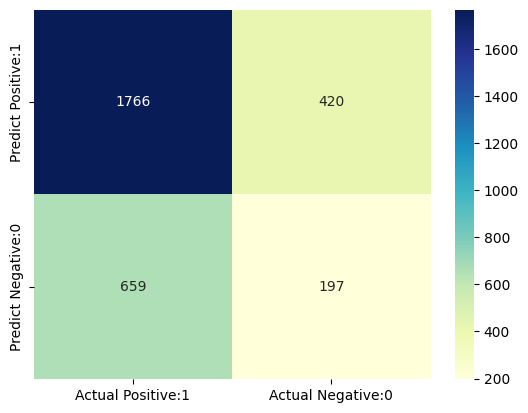

In [190]:
from sklearn.metrics import confusion_matrix

rf2_test_cls_cm = confusion_matrix(y_test, y_test_pred)

print('Confusion matrix\n\n', rf2_test_cls_cm)
print('\nTrue Positives(TP) = ', rf2_test_cls_cm[0,0])
print('\nTrue Negatives(TN) = ', rf2_test_cls_cm[1,1])
print('\nFalse Positives(FP) = ', rf2_test_cls_cm[0,1])
print('\nFalse Negatives(FN) = ', rf2_test_cls_cm[1,0])


rf2_cls_test_cm_mat = pd.DataFrame(data=rf2_test_cls_cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(rf2_cls_test_cm_mat, annot=True, fmt='d', cmap='YlGnBu')


Text(0.5, 0, 'False Positive Rate')

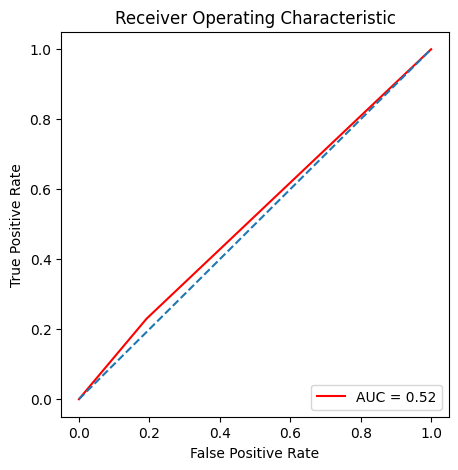

In [188]:
from sklearn.metrics import roc_curve

X = scn2_df_train_gender_pred_x.copy().values
y = scn2_df_train_gender_pred_y.copy().values
X_test = scn2_df_test_gender_pred_x.copy().values
y_test = scn2_df_test_gender_pred_y.copy().values

roc_curve(y_test, y_test_pred)

#y_preds_proba = rf_cls.predict_proba(X)
#y_preds_proba

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred)
train_roc_auc = auc(false_positive_rate, true_positive_rate)
train_roc_auc


import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % train_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Gender Classification using Stacking Classifier Model

In [173]:
from sklearn.ensemble import StackingClassifier

X = scn2_df_train_gender_pred_x.copy().values
y = scn2_df_train_gender_pred_y.copy().values
X_test = scn2_df_test_gender_pred_x.copy().values
y_test = scn2_df_test_gender_pred_y.copy().values

estimators = [
    ('Logistic Regression', logreg),
    ('Random Forest Classifier', rf_cls)
]
stackCls2 = StackingClassifier(
    estimators=estimators,
    n_jobs=-1,
    cv=5,
    verbose=10,
    final_estimator=XGBClassifier(random_state=1001, objective= 'binary:logistic', nthread=4, silent=True, colsample_by_tree=1.0, gamma=1.5, learning_rate=0.05,
              n_estimators=180, subsample=0.6)
)

stackCls2.fit(X, y).score(X_test, y_test)

[15:21:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "colsample_by_tree", "silent" } are not used.



0.7126890203813281

In [176]:
stackCls2_y_train_preds = stackCls2.predict(X)
stackCls2_y_test_preds = stackCls2.predict(X_test)

In [178]:
from sklearn.metrics import classification_report

print(classification_report(y, stackCls2_y_train_preds))

              precision    recall  f1-score   support

           0       0.71      0.99      0.83      6265
           1       0.62      0.06      0.11      2642

    accuracy                           0.71      8907
   macro avg       0.67      0.52      0.47      8907
weighted avg       0.69      0.71      0.61      8907



Confusion matrix

 [[6172   93]
 [2488  154]]

True Positives(TP) =  6172

True Negatives(TN) =  154

False Positives(FP) =  93

False Negatives(FN) =  2488


<AxesSubplot: >

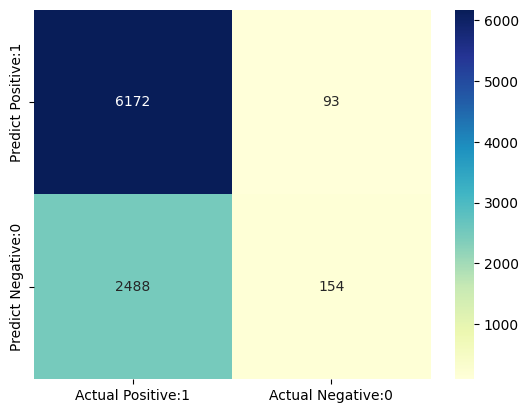

In [180]:
from sklearn.metrics import confusion_matrix

stackCls2_cm = confusion_matrix(y, stackCls2_y_train_preds)

print('Confusion matrix\n\n', stackCls2_cm)
print('\nTrue Positives(TP) = ', stackCls2_cm[0,0])
print('\nTrue Negatives(TN) = ', stackCls2_cm[1,1])
print('\nFalse Positives(FP) = ', stackCls2_cm[0,1])
print('\nFalse Negatives(FN) = ', stackCls2_cm[1,0])


stackCls2_cm_matrix = pd.DataFrame(data=stackCls2_cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(stackCls2_cm_matrix, annot=True, fmt='d', cmap='YlGnBu')


In [183]:
from sklearn.metrics import roc_curve

X = scn2_df_train_gender_pred_x.copy().values
y = scn2_df_train_gender_pred_y.copy().values
X_test = scn2_df_test_gender_pred_x.copy().values
y_test = scn2_df_test_gender_pred_y.copy().values

roc_curve(y, stackCls2_y_train_preds)

#y2_test_preds_proba = stackCls2.predict_proba(X)
#y2_test_preds_proba

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y, stackCls2_y_train_preds)
train_roc_auc = auc(false_positive_rate, true_positive_rate)
train_roc_auc


import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % train_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Text(0.5, 0, 'False Positive Rate')

In [179]:
print(classification_report(y_test, stackCls2_y_test_preds))

              precision    recall  f1-score   support

           0       0.72      0.98      0.83      2186
           1       0.39      0.04      0.07       856

    accuracy                           0.71      3042
   macro avg       0.56      0.51      0.45      3042
weighted avg       0.63      0.71      0.62      3042



In [181]:
from sklearn.metrics import confusion_matrix

stackCls2_cm_test = confusion_matrix(y_test, stackCls2_y_test_preds)

print('Confusion matrix\n\n', stackCls2_cm_test)
print('\nTrue Positives(TP) = ', stackCls2_cm_test[0,0])
print('\nTrue Negatives(TN) = ', stackCls2_cm_test[1,1])
print('\nFalse Positives(FP) = ', stackCls2_cm_test[0,1])
print('\nFalse Negatives(FN) = ', stackCls2_cm_test[1,0])


stackCls2_test_cm_matrix = pd.DataFrame(data=stackCls2_cm_test, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(stackCls2_test_cm_matrix, annot=True, fmt='d', cmap='YlGnBu')


Confusion matrix

 [[2136   50]
 [ 824   32]]

True Positives(TP) =  2136

True Negatives(TN) =  32

False Positives(FP) =  50

False Negatives(FN) =  824


<AxesSubplot: >

Text(0.5, 0, 'False Positive Rate')

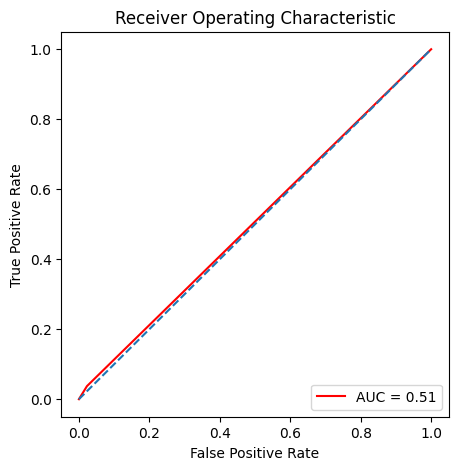

In [182]:
from sklearn.metrics import roc_curve

X = scn2_df_train_gender_pred_x.copy().values
y = scn2_df_train_gender_pred_y.copy().values
X_test = scn2_df_test_gender_pred_x.copy().values
y_test = scn2_df_test_gender_pred_y.copy().values

roc_curve(y_test, stackCls2_y_test_preds)

#y2_test_preds_proba = stackCls2.predict_proba(X)
#y2_test_preds_proba

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, stackCls2_y_test_preds)
train_roc_auc = auc(false_positive_rate, true_positive_rate)
train_roc_auc


import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % train_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')